# Service Desk Ticket Analysis Using Machine Learning

Modern IT environments generate a high volume of service desk tickets daily, ranging from minor issues to critical incidents. Managing this flow efficiently is essential for maintaining service quality and ensuring rapid response. Traditional ITSM frameworks like ITIL provide structured processes, but as ticket volumes and complexity increase, manual handling leads to delays, misclassifications, and reduced customer satisfaction.

This project explores how machine learning can be applied to service desk ticket analysis to enhance operational efficiency, improve accuracy, and embed predictive intelligence into IT service management workflows.

### Objectives

The initiative focuses on four key areas where data-driven models can significantly improve service desk operations:

1. **High-Priority Ticket Prediction:** Build predictive models to identify tickets that are likely to escalate into Priority 1 or 2 incidents, allowing teams to act proactively and minimize impact.

2. **Incident Volume Forecasting:** Use historical time-based data to forecast ticket volumes quarterly and annually, supporting better resource planning and capacity management.

3. **Automated Classification of Tickets:** Develop classifiers to automatically assign appropriate priority levels and departments, reducing delays caused by misrouted or miscategorized tickets.

4. **RFC and Misconfiguration Risk Prediction:** Predict the likelihood that a ticket will lead to a Request for Change (RFC) or result in a system misconfiguration, enabling smarter change control decisions.

### Feature Analysis

|Feature Name|Feature Description|
|------------|-------------------|
|Asset_ID|Unique identifier of the impacted configuration item.|
|Asset_Group|Main classification of the configuration item.|
|Asset_Subtype|Specific subtype under the configuration item group.|
|Budget_Code|Financial or project-linked reference code.|
|Ticket_ID|Unique incident reference number.|
|Ticket_State|Current state of the ticket (e.g., Open, Closed).|
|Business_Impact|Assessed level of disruption caused to business operations.|
|Time_Criticality|Degree of urgency for the issue to be addressed.|
|Response_Priority|Combined score reflecting how quickly a resolution is required.|
|Client_Contact_Score|Numeric representation of customer engagement or frequency.|
|Issue_Type|The nature or category of the issue reported.|
|Knowledge_Link_ID|Associated knowledge base article for issue resolution.|
|Monitoring_Origin|Indicates if the issue originated from monitoring/alert tools.|
|Team_Reassignments|Number of times the ticket changed hands between resolver groups.|
|Logged_At|Date and time when the ticket was originally logged.|
|Reinitiated_At|Timestamp indicating when the issue was reopened.|
|Solution_Completed_At|Time when a fix was implemented.|
|Final_Closure_At|Time when the ticket was completely closed.|
|Effort_Duration_Hrs|Cumulative effort in hours spent in handling the issue.|
|Closure_Rationale|Reason or explanation for closing the ticket.|
|Interaction_Tally|Total count of user interactions linked to the ticket.|
|Interaction_Ref|Unique ID(s) for the linked user interactions.|
|Incident_Link_Count|Number of related incidents tied to the main issue.|
|Change_Link_Count|Number of RFCs (Requests for Change) associated with this incident.|
|Change_Ref_ID|Unique ID referencing related change requests.|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (mean_squared_error, root_mean_squared_error, r2_score,
                             classification_report, confusion_matrix, roc_auc_score)

from imblearn.over_sampling import SMOTE

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data definition

In [5]:
desk_data = pd.read_csv(
    filepath_or_buffer="https://raw.githubusercontent.com/vishwak05/Gradious-Assignments/refs/heads/main/Desk%20Analysis%20Project/Desk%20Ticket%20Analysis.csv",
    low_memory=False
)
desk_data

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Reinitiated_At,Solution_Completed_At,Final_Closure_At,Effort_Duration_Hrs,Closure_Rationale,Interaction_Tally,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46601,SBA000464,application,Server Based Application,WBS000073,IM0047053,Closed,4,4,4.0,0.231896,...,NaN,31-03-2014 16:29,31-03-2014 16:29,"0,095",Other,1.0,SD0147021,NaN,NaN,NaN
46602,SBA000461,application,Server Based Application,WBS000073,IM0047054,Closed,4,4,4.0,0.805153,...,NaN,31-03-2014 15:29,31-03-2014 15:29,"0,428333333",User error,1.0,SD0146967,NaN,NaN,NaN
46603,LAP000019,computer,Laptop,WBS000091,IM0047055,Closed,5,5,5.0,0.917466,...,NaN,31-03-2014 15:32,31-03-2014 15:32,"0,071666667",Hardware,1.0,SD0146982,NaN,NaN,NaN
46604,WBA000058,application,Web Based Application,WBS000073,IM0047056,Closed,4,4,4.0,0.701278,...,NaN,31-03-2014 15:42,31-03-2014 15:42,"0,116944444",Software,1.0,SD0146986,NaN,NaN,NaN


In [6]:
desk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Asset_ID               46606 non-null  object 
 1   Asset_Group            46495 non-null  object 
 2   Asset_Subtype          46495 non-null  object 
 3   Budget_Code            46606 non-null  object 
 4   Ticket_ID              46606 non-null  object 
 5   Ticket_State           46606 non-null  object 
 6   Business_Impact        46606 non-null  object 
 7   Time_Criticality       46606 non-null  object 
 8   Response_Priority      45226 non-null  float64
 9   Client_Contact_Score   46606 non-null  float64
 10  Issue_Type             46606 non-null  object 
 11  Knowledge_Link_ID      46606 non-null  object 
 12  Monitoring_Origin      46606 non-null  object 
 13  Team_Reassignments     46605 non-null  float64
 14  Logged_At              46606 non-null  object 
 15  Re

In [7]:
desk_data.describe()

,Response_Priority,Client_Contact_Score,Team_Reassignments,Interaction_Tally,Incident_Link_Count,Change_Link_Count
count,45226.000000,46606.000000,46605.000000,46492.000000,1222.000000,560.000000
mean,4.215805,0.499658,1.131831,1.149897,1.669394,1.058929
std,0.705624,0.288634,2.269774,2.556338,3.339687,0.403596
min,1.000000,0.000023,0.000000,1.000000,1.000000,1.000000
25%,4.000000,0.248213,0.000000,1.000000,1.000000,1.000000
50%,4.000000,0.500269,0.000000,1.000000,1.000000,1.000000
75%,5.000000,0.749094,2.000000,1.000000,1.000000,1.000000
max,5.000000,0.999997,46.000000,370.000000,63.000000,9.000000


# Data Pre-processing

### Handling Duplicates

In [8]:
desk_data.duplicated().sum()

np.int64(0)

In [9]:
desk_data['Asset_ID'].duplicated().sum()

np.int64(43587)

In [10]:
desk_data['Budget_Code'].duplicated().sum()

np.int64(46332)

In [11]:
desk_data['Ticket_ID'].duplicated().sum()

np.int64(0)

In [12]:
desk_data.isna().sum()

,0
Asset_ID,0
Asset_Group,111
Asset_Subtype,111
Budget_Code,0
Ticket_ID,0
Ticket_State,0
Business_Impact,0
Time_Criticality,0
Response_Priority,1380
Client_Contact_Score,0


In [13]:
for col in desk_data.columns:
    print(desk_data[col].value_counts(dropna=False), end='\n\n')

Asset_ID
SUB000456    3050
SBA000263    2176
SBA000607    1743
SBA000462    1698
WBA000058    1614
             ... 
HMD000018       1
CBD000893       1
RTR000027       1
CBD000870       1
DSK000330       1
Name: count, Length: 3019, dtype: int64

Asset_Group
application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
NaN                       111
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: count, dtype: int64

Asset_Subtype
Server Based Application           18811
Web Based Application              15311
Desktop Application                 3876
Laptop                              1921
SAP                                 1199
                                   ...  
Windows Server in extern beheer        1
Virtual Tape Server   

### Drop cols, NS to NaN

In [14]:
# Dropping unecessary features
desk_data.drop(columns=["Monitoring_Origin"], inplace=True)

In [15]:
# Convert NS values to NaN
desk_data['Business_Impact'] = desk_data['Business_Impact'].replace("NS", np.nan)

In [16]:
desk_data[desk_data['Time_Criticality'] == "5 - Very Low"]

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Reinitiated_At,Solution_Completed_At,Final_Closure_At,Effort_Duration_Hrs,Closure_Rationale,Interaction_Tally,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID
38305,SBA000743,application,Server Based Application,WBS000076,IM0038625,Closed,5,5 - Very Low,5.0,0.229756,...,NaN,20-02-2014 15:57,20-02-2014 15:57,"0,089166667",No error - works as designed,1.0,SD0117519,NaN,NaN,NaN


In [17]:
# Converting "5 - Very Low" label to "5" label
desk_data['Time_Criticality'] = desk_data['Time_Criticality'].replace("5 - Very Low", "5")

In [18]:
# Converting to float dtype
desk_data[['Time_Criticality', 'Business_Impact']] = desk_data[['Time_Criticality', 'Business_Impact']].astype('float')

In [19]:
desk_data['Business_Impact'].value_counts(dropna=False)

,count
Business_Impact,
4.0,22556
5.0,16741
3.0,5234
NaN,1380
2.0,692
1.0,3


In [20]:
# Checking if response priority is calculated based on business impact and time criticality
desk_data.groupby(['Business_Impact', 'Time_Criticality'])['Response_Priority'].value_counts()

Business_Impact  Time_Criticality  Response_Priority
1.0              1.0               1.0                      3
2.0              2.0               2.0                    689
                 3.0               2.0                      3
3.0              1.0               2.0                      2
                 2.0               2.0                      3
                 3.0               3.0                   5077
                 4.0               3.0                    144
                 5.0               4.0                      8
4.0              2.0               3.0                      3
                 3.0               3.0                     97
                 4.0               4.0                  22170
                 5.0               4.0                    286
5.0              1.0               3.0                      1
                 2.0               3.0                      1
                 3.0               4.0                     11
                 4.0               4.0                    242
                 5.0               5.0                  16486
Name: count, dtype: int64

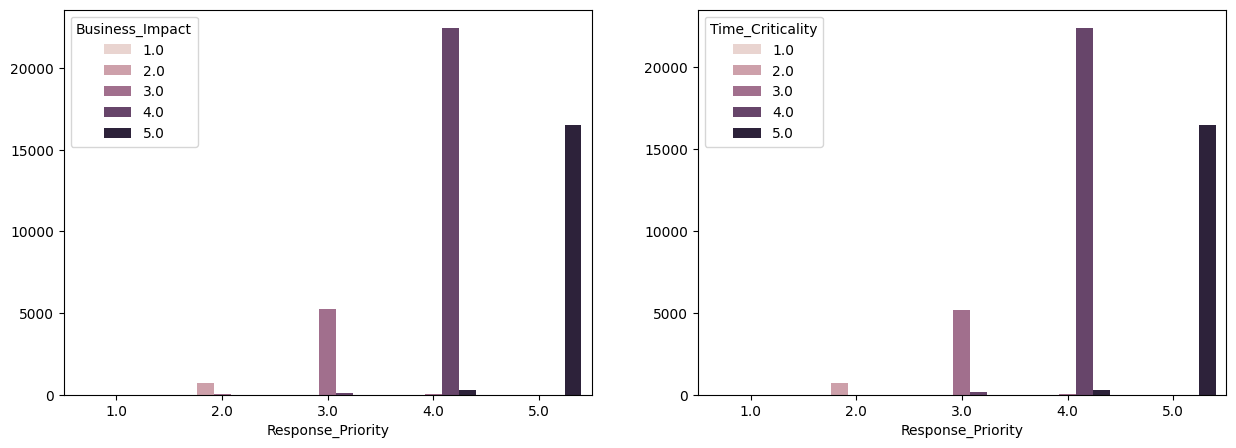

In [21]:
# Check if response prioirty is related to business impact and time criticality
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(data=desk_data, x="Response_Priority", hue="Business_Impact")
plt.ylabel('')

plt.subplot(1,2,2)
sns.countplot(data=desk_data, x="Response_Priority", hue="Time_Criticality")
plt.ylabel('')

plt.show()

In [22]:
# Checking the relation between Time_Criticality and Business_Impact
desk_data.groupby(['Time_Criticality'])['Business_Impact'].value_counts()

Time_Criticality  Business_Impact
1.0               1.0                    3
                  3.0                    2
                  5.0                    1
2.0               2.0                  689
                  3.0                    3
                  4.0                    3
                  5.0                    1
3.0               3.0                 5077
                  4.0                   97
                  5.0                   11
                  2.0                    3
4.0               4.0                22170
                  5.0                  242
                  3.0                  144
5.0               5.0                16486
                  4.0                  286
                  3.0                    8
Name: count, dtype: int64

<Axes: xlabel='Business_Impact', ylabel='count'>

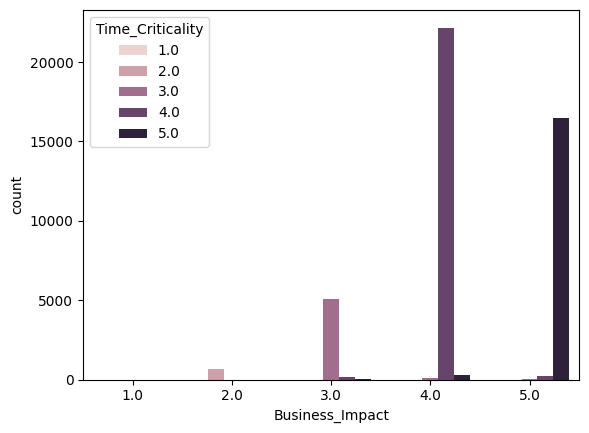

In [23]:
# Relation between Business_Impact and Time_Criticality
sns.countplot(data=desk_data, x="Business_Impact", hue="Time_Criticality")

In [24]:
# NA rows in Response_Priority
desk_data[desk_data['Response_Priority'].isna()]

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Reinitiated_At,Solution_Completed_At,Final_Closure_At,Effort_Duration_Hrs,Closure_Rationale,Interaction_Tally,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NaN,3.0,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
8,WBA000124,application,Web Based Application,WBS000088,IM0000017,Closed,NaN,3.0,NaN,0.269574,...,NaN,08-11-2013 14:02,08-11-2013 14:02,"0,862777778",Other,1.0,SD0000036,NaN,NaN,NaN
103,SBA000782,application,Server Based Application,WBS000043,IM0000151,Closed,NaN,3.0,NaN,0.610829,...,NaN,17-10-2013 15:03,17-10-2013 15:03,"9,64,76,66,667",Other,1.0,SD0000177,NaN,NaN,NaN
147,SBA000782,application,Server Based Application,WBS000043,IM0000199,Closed,NaN,3.0,NaN,0.724279,...,NaN,09-12-2013 14:49,09-12-2013 14:50,"11,26,525",Other,1.0,SD0000228,NaN,NaN,NaN
152,SBA000782,application,Server Based Application,WBS000043,IM0000205,Closed,NaN,3.0,NaN,0.374449,...,NaN,09-12-2013 14:46,09-12-2013 14:46,"1,11,86,48,333",Other,1.0,SD0000233,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46424,SBA000172,application,Server Based Application,WBS000014,IM0046873,Closed,NaN,3.0,NaN,0.343793,...,NaN,31-03-2014 09:20,31-03-2014 09:20,"1,01,97,22,222",Other,1.0,SD0146117,NaN,NaN,NaN
46446,ADB000010,database,Database,WBS000239,IM0046895,Closed,NaN,3.0,NaN,0.647066,...,NaN,31-03-2014 11:14,31-03-2014 11:14,"3,01,11,11,111",User error,1.0,SD0146192,NaN,NaN,NaN
46484,SBA000759,application,Server Based Application,WBS000296,IM0046934,Closed,NaN,3.0,NaN,0.722611,...,NaN,31-03-2014 11:10,31-03-2014 11:10,"0,39",Other,1.0,SD0146455,NaN,NaN,NaN
46553,CNT000046,storage,Controller,WBS000183,IM0047005,Closed,NaN,3.0,NaN,0.123493,...,NaN,31-03-2014 20:35,31-03-2014 20:35,"0,485277778",Hardware,1.0,SD0146607,NaN,NaN,NaN


In [25]:
desk_data[desk_data['Response_Priority'].isna()]['Business_Impact'].value_counts(dropna=False)

,count
Business_Impact,
NaN,1380


Findings:
- *Response_Priority* is calculated using *Business_Impact* and *Time_Criticality*
$Response Priority: Round(\frac{Business Impact + Time Criticality}{2})$

- The NaN values in *Response_Priority* are due to NaN values in *Business_Impact*

### Converting Effort_Duration_Hrs into Integar values

In [26]:
desk_data['Effort_Duration_Hrs'].value_counts(dropna=False)

,count
Effort_Duration_Hrs,
0,236
"0,034444444",23
"0,018333333",22
"0,016666667",19
"0,021388889",19
...,...
"2,54,80,55,556",1
"1,03,02,77,778",1
"1,18,36,11,111",1


- *Effort_Duration_Hrs* is in String format with commas. eg: 1,234,874
- Removing commas in string and converting into integer

In [27]:
desk_data['Effort_Duration_Hrs'].isna().sum()

np.int64(1)

In [28]:
# Dropping NA rows (No major affect as it's only 1 row)
desk_data.dropna(subset=['Effort_Duration_Hrs'], inplace=True)

In [29]:
# Method to remove commas and convert into float dtype
def clean_effort_duration(x):

    if pd.isna(x):
        return np.nan

    x = str(x).strip()

    # If only 1 comma then it's a decimal value
    if x.count(",") == 1:
        return float(x.replace(",", "."))

    # Else it's integer
    if x.count(",") > 1:
        return float(x.replace(",", ""))

    return float(x)

In [30]:
# Applying the method to Effort_Duration_Hrs column
desk_data['Effort_Duration_Hrs'] = desk_data['Effort_Duration_Hrs'].apply(clean_effort_duration)

In [31]:
desk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46605 entries, 0 to 46605
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Asset_ID               46605 non-null  object 
 1   Asset_Group            46494 non-null  object 
 2   Asset_Subtype          46494 non-null  object 
 3   Budget_Code            46605 non-null  object 
 4   Ticket_ID              46605 non-null  object 
 5   Ticket_State           46605 non-null  object 
 6   Business_Impact        45225 non-null  float64
 7   Time_Criticality       46605 non-null  float64
 8   Response_Priority      45225 non-null  float64
 9   Client_Contact_Score   46605 non-null  float64
 10  Issue_Type             46605 non-null  object 
 11  Knowledge_Link_ID      46605 non-null  object 
 12  Team_Reassignments     46605 non-null  float64
 13  Logged_At              46605 non-null  object 
 14  Reinitiated_At         2284 non-null   object 
 15  Solutio

### Imputing NA values using KNN Imputer

- Columns to drop NA rows: *Asset_Group* and *Asset_Subtype*
- Columns to impute: *Business_Impact* and *Response_Priority*

In [32]:
# NA values in Asset_Subtype is due to NA values in Asset_Group
desk_data[desk_data['Asset_Group'].isna()]['Asset_Subtype'].value_counts(dropna=False)

,count
Asset_Subtype,
NaN,111


In [33]:
# Dropping NA rows in Asset_Group, which also clears NA values in Asset_Subtype
desk_data.dropna(subset=['Asset_Group'], inplace=True)

In [34]:
# Cols we can using for imputing NA values
impute_cols = ['Business_Impact', 'Time_Criticality', 'Response_Priority',
               'Issue_Type', 'Asset_Group', 'Asset_Subtype',
               'Effort_Duration_Hrs', 'Client_Contact_Score']

desk_data_impute = desk_data[impute_cols]

desk_data_impute

,Business_Impact,Time_Criticality,Response_Priority,Issue_Type,Asset_Group,Asset_Subtype,Effort_Duration_Hrs,Client_Contact_Score
0,4.0,4.0,4.0,incident,subapplication,Web Based Application,3.871691e+09,0.601292
1,3.0,3.0,3.0,incident,application,Web Based Application,4.354786e+09,0.415050
2,NaN,3.0,NaN,request for information,application,Desktop Application,4.843119e+09,0.517551
3,4.0,4.0,4.0,incident,application,Web Based Application,4.321833e+09,0.642927
4,4.0,4.0,4.0,incident,application,Web Based Application,3.383903e+09,0.345258
...,...,...,...,...,...,...,...,...
46601,4.0,4.0,4.0,incident,application,Server Based Application,9.500000e-02,0.231896
46602,4.0,4.0,4.0,incident,application,Server Based Application,4.283333e-01,0.805153
46603,5.0,5.0,5.0,incident,computer,Laptop,7.166667e-02,0.917466
46604,4.0,4.0,4.0,incident,application,Web Based Application,1.169444e-01,0.701278


In [35]:
scaler = StandardScaler()
le = LabelEncoder()

num_cols = ['Effort_Duration_Hrs', 'Client_Contact_Score']
cat_cols = ['Issue_Type', 'Asset_Group', 'Asset_Subtype']

desk_data_impute.loc[:,num_cols] = scaler.fit_transform(desk_data_impute[num_cols])
desk_data_impute.loc[:,cat_cols] = desk_data_impute[cat_cols].apply(le.fit_transform)
desk_data_impute

,Business_Impact,Time_Criticality,Response_Priority,Issue_Type,Asset_Group,Asset_Subtype,Effort_Duration_Hrs,Client_Contact_Score
0,4.0,4.0,4.0,1,11,57,0.617151,0.352031
1,3.0,3.0,3.0,1,1,57,0.807655,-0.293164
2,NaN,3.0,NaN,2,1,10,1.000224,0.061929
3,4.0,4.0,4.0,1,1,57,0.794660,0.496266
4,4.0,4.0,4.0,1,1,57,0.424797,-0.534942
...,...,...,...,...,...,...,...,...
46601,4.0,4.0,4.0,1,1,45,-0.909612,-0.927661
46602,4.0,4.0,4.0,1,1,45,-0.909612,1.058261
46603,5.0,5.0,5.0,1,3,21,-0.909612,1.447346
46604,4.0,4.0,4.0,1,1,57,-0.909612,0.698410


In [36]:
imputer = KNNImputer(n_neighbors=5)

desk_data_imputed_array = imputer.fit_transform(desk_data_impute)

desk_data_imputed = pd.DataFrame(
    desk_data_imputed_array,
    columns=impute_cols,
    index=desk_data_impute.index
    )
desk_data_imputed

,Business_Impact,Time_Criticality,Response_Priority,Issue_Type,Asset_Group,Asset_Subtype,Effort_Duration_Hrs,Client_Contact_Score
0,4.0,4.0,4.0,1.0,11.0,57.0,0.617151,0.352031
1,3.0,3.0,3.0,1.0,1.0,57.0,0.807655,-0.293164
2,3.2,3.0,3.0,2.0,1.0,10.0,1.000224,0.061929
3,4.0,4.0,4.0,1.0,1.0,57.0,0.794660,0.496266
4,4.0,4.0,4.0,1.0,1.0,57.0,0.424797,-0.534942
...,...,...,...,...,...,...,...,...
46601,4.0,4.0,4.0,1.0,1.0,45.0,-0.909612,-0.927661
46602,4.0,4.0,4.0,1.0,1.0,45.0,-0.909612,1.058261
46603,5.0,5.0,5.0,1.0,3.0,21.0,-0.909612,1.447346
46604,4.0,4.0,4.0,1.0,1.0,57.0,-0.909612,0.698410


In [37]:
desk_data_imputed['Business_Impact'].value_counts(dropna=False)

,count
Business_Impact,
4.0,22558
5.0,16681
3.0,6412
2.0,684
3.2,101
3.4,36
3.8,5
2.8,5
4.2,4


In [38]:
desk_data_imputed['Response_Priority'].value_counts(dropna=False)

,count
Response_Priority,
4.0,22720
5.0,16426
3.0,6602
2.0,689
3.2,28
3.4,10
3.8,5
2.8,5
3.6,3


In [39]:
# Rounding the imputed values to clear labels
desk_data_imputed[['Business_Impact', 'Response_Priority']] = desk_data_imputed[['Business_Impact', 'Response_Priority']].round()

In [40]:
# Adding imputed cols into original data
desk_data[['Business_Impact', 'Response_Priority']] = desk_data_imputed[['Business_Impact', 'Response_Priority']]
desk_data

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Reinitiated_At,Solution_Completed_At,Final_Closure_At,Effort_Duration_Hrs,Closure_Rationale,Interaction_Tally,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,4.0,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,3.871691e+09,Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3.0,3.0,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,4.354786e+09,Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,3.0,3.0,3.0,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,4.843119e+09,No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4.0,4.0,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,4.321833e+09,Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4.0,4.0,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,3.383903e+09,Other,1.0,SD0000029,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46601,SBA000464,application,Server Based Application,WBS000073,IM0047053,Closed,4.0,4.0,4.0,0.231896,...,NaN,31-03-2014 16:29,31-03-2014 16:29,9.500000e-02,Other,1.0,SD0147021,NaN,NaN,NaN
46602,SBA000461,application,Server Based Application,WBS000073,IM0047054,Closed,4.0,4.0,4.0,0.805153,...,NaN,31-03-2014 15:29,31-03-2014 15:29,4.283333e-01,User error,1.0,SD0146967,NaN,NaN,NaN
46603,LAP000019,computer,Laptop,WBS000091,IM0047055,Closed,5.0,5.0,5.0,0.917466,...,NaN,31-03-2014 15:32,31-03-2014 15:32,7.166667e-02,Hardware,1.0,SD0146982,NaN,NaN,NaN
46604,WBA000058,application,Web Based Application,WBS000073,IM0047056,Closed,4.0,4.0,4.0,0.701278,...,NaN,31-03-2014 15:42,31-03-2014 15:42,1.169444e-01,Software,1.0,SD0146986,NaN,NaN,NaN


In [41]:
desk_data.isna().sum()

,0
Asset_ID,0
Asset_Group,0
Asset_Subtype,0
Budget_Code,0
Ticket_ID,0
Ticket_State,0
Business_Impact,0
Time_Criticality,0
Response_Priority,0
Client_Contact_Score,0


In [42]:
for col in desk_data.columns:
    print(desk_data[col].value_counts(dropna=False), end='\n\n')

Asset_ID
SUB000456    3050
SBA000263    2176
SBA000607    1743
SBA000462    1698
WBA000058    1614
             ... 
XSR000092       1
DSK000544       1
CBD000286       1
SAN000145       1
SBA000152       1
Name: count, Length: 2999, dtype: int64

Asset_Group
application             32899
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: count, dtype: int64

Asset_Subtype
Server Based Application           18810
Web Based Application              15311
Desktop Application                 3876
Laptop                              1921
SAP                                 1199
                                   ...  
Windows Server in extern beheer        1
Virtual Tape Server                    1
RAC Service

### Handling Date Cols

Date columns: *Logged_At, Reinitiated_At, Solution_Completed_At, Final_Closure_At*

- Currently in str format due to NA values
- Converting into DateTime format with NAT values
- Creating new cols of time difference from *Logged_At* to all other cols
- Converting *Logged_Num* into numeric value (UNIX Time)

In [43]:
date_cols = ['Logged_At', 'Reinitiated_At', 'Solution_Completed_At', 'Final_Closure_At']

In [44]:
desk_data[date_cols]

,Logged_At,Reinitiated_At,Solution_Completed_At,Final_Closure_At
0,05-02-2012 13:32,NaN,04-11-2013 13:50,04-11-2013 13:51
1,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36
2,29-03-2012 12:36,NaN,13-01-2014 15:12,13-01-2014 15:13
3,17-07-2012 11:49,NaN,14-11-2013 09:31,14-11-2013 09:31
4,10-08-2012 11:01,NaN,08-11-2013 13:55,08-11-2013 13:55
...,...,...,...,...
46601,31-03-2014 16:23,NaN,31-03-2014 16:29,31-03-2014 16:29
46602,31-03-2014 15:03,NaN,31-03-2014 15:29,31-03-2014 15:29
46603,31-03-2014 15:28,NaN,31-03-2014 15:32,31-03-2014 15:32
46604,31-03-2014 15:35,NaN,31-03-2014 15:42,31-03-2014 15:42


In [45]:
for col in date_cols:
    desk_data[col] = pd.to_datetime(desk_data[col], dayfirst=True)

In [46]:
desk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46494 entries, 0 to 46605
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Asset_ID               46494 non-null  object        
 1   Asset_Group            46494 non-null  object        
 2   Asset_Subtype          46494 non-null  object        
 3   Budget_Code            46494 non-null  object        
 4   Ticket_ID              46494 non-null  object        
 5   Ticket_State           46494 non-null  object        
 6   Business_Impact        46494 non-null  float64       
 7   Time_Criticality       46494 non-null  float64       
 8   Response_Priority      46494 non-null  float64       
 9   Client_Contact_Score   46494 non-null  float64       
 10  Issue_Type             46494 non-null  object        
 11  Knowledge_Link_ID      46494 non-null  object        
 12  Team_Reassignments     46494 non-null  float64       
 13  Logged

In [47]:
desk_data[date_cols]

,Logged_At,Reinitiated_At,Solution_Completed_At,Final_Closure_At
0,2012-02-05 13:32:00,NaT,2013-11-04 13:50:00,2013-11-04 13:51:00
1,2012-03-12 15:44:00,2013-12-02 12:31:00,2013-12-02 12:36:00,2013-12-02 12:36:00
2,2012-03-29 12:36:00,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00
3,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00
4,2012-08-10 11:01:00,NaT,2013-11-08 13:55:00,2013-11-08 13:55:00
...,...,...,...,...
46601,2014-03-31 16:23:00,NaT,2014-03-31 16:29:00,2014-03-31 16:29:00
46602,2014-03-31 15:03:00,NaT,2014-03-31 15:29:00,2014-03-31 15:29:00
46603,2014-03-31 15:28:00,NaT,2014-03-31 15:32:00,2014-03-31 15:32:00
46604,2014-03-31 15:35:00,NaT,2014-03-31 15:42:00,2014-03-31 15:42:00


In [48]:
# Time delta from Logged_At
desk_data["Time_For_Reinitiated"] = desk_data['Reinitiated_At'] - desk_data['Logged_At']
desk_data["Time_For_Solution_Completed"] = desk_data['Solution_Completed_At'] - desk_data['Logged_At']
desk_data["Time_For_Final_Closure"] = desk_data['Final_Closure_At'] - desk_data['Logged_At']

In [49]:
# Time delta into numeric
desk_data['Time_For_Reinitiated'] = desk_data['Time_For_Reinitiated'].dt.total_seconds() / 86400
desk_data['Time_For_Solution_Completed'] = desk_data['Time_For_Solution_Completed'].dt.total_seconds() / 86400
desk_data['Time_For_Final_Closure'] = desk_data['Time_For_Final_Closure'].dt.total_seconds() / 86400

In [50]:
# Filling NA values with 0 indicating not initiated
desk_data["Time_For_Reinitiated"] = desk_data["Time_For_Reinitiated"].fillna(0)
desk_data["Time_For_Solution_Completed"] = desk_data["Time_For_Solution_Completed"].fillna(0)
desk_data["Time_For_Final_Closure"] = desk_data["Time_For_Final_Closure"].fillna(0)

In [51]:
# Binary label if initiated or not
desk_data["Was_Reinitiated"] = desk_data["Reinitiated_At"].notna().astype('float')
desk_data["Was_Solution_Completed"] = desk_data["Solution_Completed_At"].notna().astype('float')

In [52]:
# Logged_At into numeric value (UNIX Time)
desk_data["Logged_At_Num"] = (desk_data['Logged_At'].astype(np.int64) // 10**9).astype('float')

<Axes: xlabel='Logged_At'>

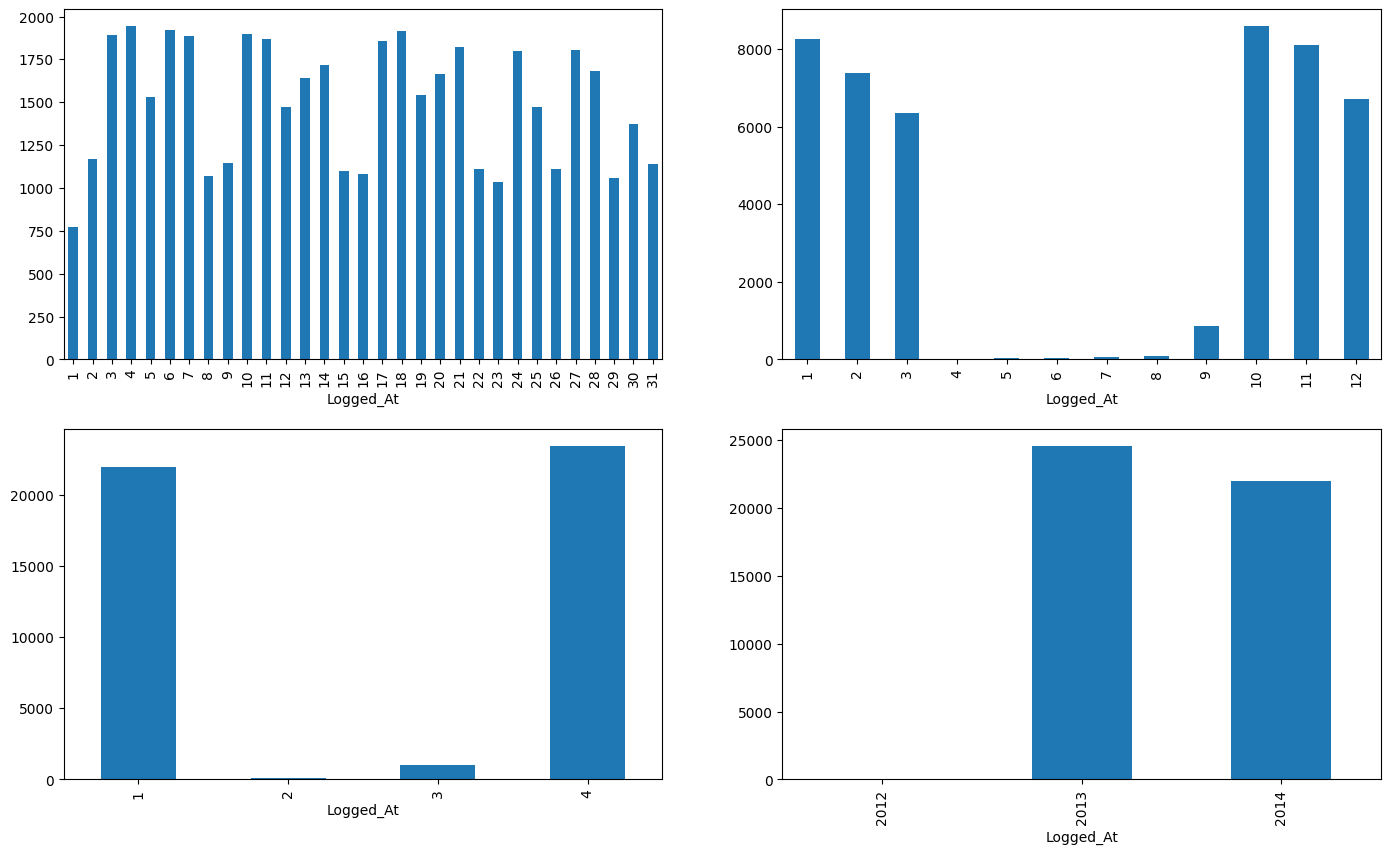

In [53]:
# daily, weekly, monthly, quarterly, yearly trends in ticket logging
plt.figure(figsize=(17, 10))

plt.subplot(2, 2, 1)
desk_data['Logged_At'].dt.day.value_counts().sort_index().plot(kind='bar')

plt.subplot(2, 2, 2)
desk_data['Logged_At'].dt.month.value_counts().sort_index().plot(kind='bar')

plt.subplot(2, 2, 3)
desk_data['Logged_At'].dt.quarter.value_counts().sort_index().plot(kind='bar')

plt.subplot(2, 2, 4)
desk_data['Logged_At'].dt.year.value_counts().sort_index().plot(kind='bar')

In [54]:
desk_data

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4.0,4.0,4.0,0.601292,...,SD0000007,2.0,NaN,NaN,0.000000,638.012500,638.013194,0.0,1.0,1.328449e+09
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3.0,3.0,3.0,0.415050,...,SD0000011,1.0,NaN,NaN,629.865972,629.869444,629.869444,1.0,1.0,1.331567e+09
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,3.0,3.0,3.0,0.517551,...,SD0000017,NaN,NaN,NaN,0.000000,655.108333,655.109028,0.0,1.0,1.333025e+09
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4.0,4.0,4.0,0.642927,...,SD0000025,NaN,NaN,NaN,0.000000,484.904167,484.904167,0.0,1.0,1.342526e+09
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4.0,4.0,4.0,0.345258,...,SD0000029,NaN,NaN,NaN,0.000000,455.120833,455.120833,0.0,1.0,1.344596e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46601,SBA000464,application,Server Based Application,WBS000073,IM0047053,Closed,4.0,4.0,4.0,0.231896,...,SD0147021,NaN,NaN,NaN,0.000000,0.004167,0.004167,0.0,1.0,1.396283e+09
46602,SBA000461,application,Server Based Application,WBS000073,IM0047054,Closed,4.0,4.0,4.0,0.805153,...,SD0146967,NaN,NaN,NaN,0.000000,0.018056,0.018056,0.0,1.0,1.396278e+09
46603,LAP000019,computer,Laptop,WBS000091,IM0047055,Closed,5.0,5.0,5.0,0.917466,...,SD0146982,NaN,NaN,NaN,0.000000,0.002778,0.002778,0.0,1.0,1.396280e+09
46604,WBA000058,application,Web Based Application,WBS000073,IM0047056,Closed,4.0,4.0,4.0,0.701278,...,SD0146986,NaN,NaN,NaN,0.000000,0.004861,0.004861,0.0,1.0,1.396280e+09


### Handling RFC cols

- Filling NA values

In [55]:
desk_data['Closure_Rationale'] = desk_data['Closure_Rationale'].fillna("Unknown")

desk_data['Interaction_Tally'] = desk_data['Interaction_Tally'].fillna(0.0)

desk_data['Incident_Link_Count'] = desk_data['Incident_Link_Count'].fillna(0)

desk_data['Change_Link_Count'] = desk_data['Change_Link_Count'].fillna(0)

In [56]:
desk_data[desk_data['Interaction_Tally'].isna()]

,Asset_ID,Asset_Group,Asset_Subtype,Budget_Code,Ticket_ID,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,...,Interaction_Ref,Incident_Link_Count,Change_Link_Count,Change_Ref_ID,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num


Total rows - No.of "1.0" label in Interaction_Tally (Unique)

46494 - 42962 = 3532

Interaction_Ref of #MULTIVALUE and #N/B (Non-Unique or Not available)

3418 + 114 = 3532

NaN values in Interaction_Tally is 114, same as Interaction_Ref #N/B values

In [57]:
desk_data['Interaction_Ref'].fillna(0.0, inplace=True)

NaN values in Change_Link_Count is same as NaN values in Change_Ref_Id

It can be #N/B

In [58]:
desk_data['Change_Ref_ID'].fillna("#N/B", inplace=True)

In [59]:
# Dropping ID cols which have no value in modelling
desk_data.drop(columns=["Asset_ID", "Budget_Code", "Ticket_ID",
                        "Knowledge_Link_ID", "Interaction_Ref", "Change_Ref_ID"],
               inplace=True)

In [60]:
# Converting categorical cols into numeric
cat_cols = desk_data.select_dtypes('object').columns
desk_data[cat_cols] = desk_data[cat_cols].apply(le.fit_transform).astype('float')

In [61]:
desk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46494 entries, 0 to 46605
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Asset_Group                  46494 non-null  float64       
 1   Asset_Subtype                46494 non-null  float64       
 2   Ticket_State                 46494 non-null  float64       
 3   Business_Impact              46494 non-null  float64       
 4   Time_Criticality             46494 non-null  float64       
 5   Response_Priority            46494 non-null  float64       
 6   Client_Contact_Score         46494 non-null  float64       
 7   Issue_Type                   46494 non-null  float64       
 8   Team_Reassignments           46494 non-null  float64       
 9   Logged_At                    46494 non-null  datetime64[ns]
 10  Reinitiated_At               2276 non-null   datetime64[ns]
 11  Solution_Completed_At        44724 non-null  d

In [62]:
desk_data.reset_index(drop=True, inplace=True)

In [63]:
desk_data.isna().sum()

,0
Asset_Group,0
Asset_Subtype,0
Ticket_State,0
Business_Impact,0
Time_Criticality,0
Response_Priority,0
Client_Contact_Score,0
Issue_Type,0
Team_Reassignments,0
Logged_At,0


In [64]:
desk_data

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Logged_At,...,Closure_Rationale,Interaction_Tally,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num
0,11.0,57.0,0.0,4.0,4.0,4.0,0.601292,1.0,26.0,2012-02-05 13:32:00,...,6.0,1.0,2.0,0.0,0.000000,638.012500,638.013194,0.0,1.0,1.328449e+09
1,1.0,57.0,0.0,3.0,3.0,3.0,0.415050,1.0,33.0,2012-03-12 15:44:00,...,10.0,1.0,1.0,0.0,629.865972,629.869444,629.869444,1.0,1.0,1.331567e+09
2,1.0,10.0,0.0,3.0,3.0,3.0,0.517551,2.0,3.0,2012-03-29 12:36:00,...,4.0,1.0,0.0,0.0,0.000000,655.108333,655.109028,0.0,1.0,1.333025e+09
3,1.0,57.0,0.0,4.0,4.0,4.0,0.642927,1.0,13.0,2012-07-17 11:49:00,...,5.0,1.0,0.0,0.0,0.000000,484.904167,484.904167,0.0,1.0,1.342526e+09
4,1.0,57.0,0.0,4.0,4.0,4.0,0.345258,1.0,2.0,2012-08-10 11:01:00,...,6.0,1.0,0.0,0.0,0.000000,455.120833,455.120833,0.0,1.0,1.344596e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46489,1.0,45.0,0.0,4.0,4.0,4.0,0.231896,1.0,0.0,2014-03-31 16:23:00,...,6.0,1.0,0.0,0.0,0.000000,0.004167,0.004167,0.0,1.0,1.396283e+09
46490,1.0,45.0,0.0,4.0,4.0,4.0,0.805153,1.0,0.0,2014-03-31 15:03:00,...,12.0,1.0,0.0,0.0,0.000000,0.018056,0.018056,0.0,1.0,1.396278e+09
46491,3.0,21.0,0.0,5.0,5.0,5.0,0.917466,1.0,0.0,2014-03-31 15:28:00,...,1.0,1.0,0.0,0.0,0.000000,0.002778,0.002778,0.0,1.0,1.396280e+09
46492,1.0,57.0,0.0,4.0,4.0,4.0,0.701278,1.0,0.0,2014-03-31 15:35:00,...,10.0,1.0,0.0,0.0,0.000000,0.004861,0.004861,0.0,1.0,1.396280e+09


In [65]:
desk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Asset_Group                  46494 non-null  float64       
 1   Asset_Subtype                46494 non-null  float64       
 2   Ticket_State                 46494 non-null  float64       
 3   Business_Impact              46494 non-null  float64       
 4   Time_Criticality             46494 non-null  float64       
 5   Response_Priority            46494 non-null  float64       
 6   Client_Contact_Score         46494 non-null  float64       
 7   Issue_Type                   46494 non-null  float64       
 8   Team_Reassignments           46494 non-null  float64       
 9   Logged_At                    46494 non-null  datetime64[ns]
 10  Reinitiated_At               2276 non-null   datetime64[ns]
 11  Solution_Completed_At        44724 non-nu

In [66]:
desk_data.describe()

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Logged_At,...,Closure_Rationale,Interaction_Tally,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num
count,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494,...,46494.000000,46494.000000,46494.00000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,46494.000000,4.649400e+04
mean,3.140190,41.750807,0.000194,4.188153,4.189379,4.180496,0.499675,1.189723,1.132555,2013-12-24 10:50:22.414505216,...,7.126253,1.147008,0.04293,0.012690,0.482561,5.002313,5.134577,0.048953,0.961931,1.387882e+09
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000023,0.000000,0.000000,2012-02-05 13:32:00,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.328449e+09
25%,1.000000,42.000000,0.000000,4.000000,4.000000,4.000000,0.248353,1.000000,0.000000,2013-11-07 12:24:30,...,6.000000,1.000000,0.00000,0.000000,0.000000,0.043750,0.052778,0.000000,1.000000,1.383827e+09
50%,1.000000,45.000000,0.000000,4.000000,4.000000,4.000000,0.500219,1.000000,0.000000,2013-12-23 11:54:30,...,6.000000,1.000000,0.00000,0.000000,0.000000,0.709722,0.767361,0.000000,1.000000,1.387800e+09
75%,3.000000,57.000000,0.000000,5.000000,5.000000,5.000000,0.749149,1.000000,2.000000,2014-02-07 16:16:00,...,10.000000,1.000000,0.00000,0.000000,0.000000,3.899826,3.962326,0.000000,1.000000,1.391790e+09
max,11.000000,63.000000,1.000000,5.000000,5.000000,5.000000,0.999997,2.000000,46.000000,2014-03-31 17:24:00,...,13.000000,370.000000,63.00000,9.000000,629.865972,655.108333,655.109028,1.000000,1.000000,1.396287e+09
std,3.840485,17.048777,0.013912,0.723785,0.724104,0.723595,0.288664,0.392689,2.270863,NaN,...,3.404551,2.556804,0.59273,0.123447,6.956052,18.569434,18.881763,0.215771,0.191366,4.857687e+06


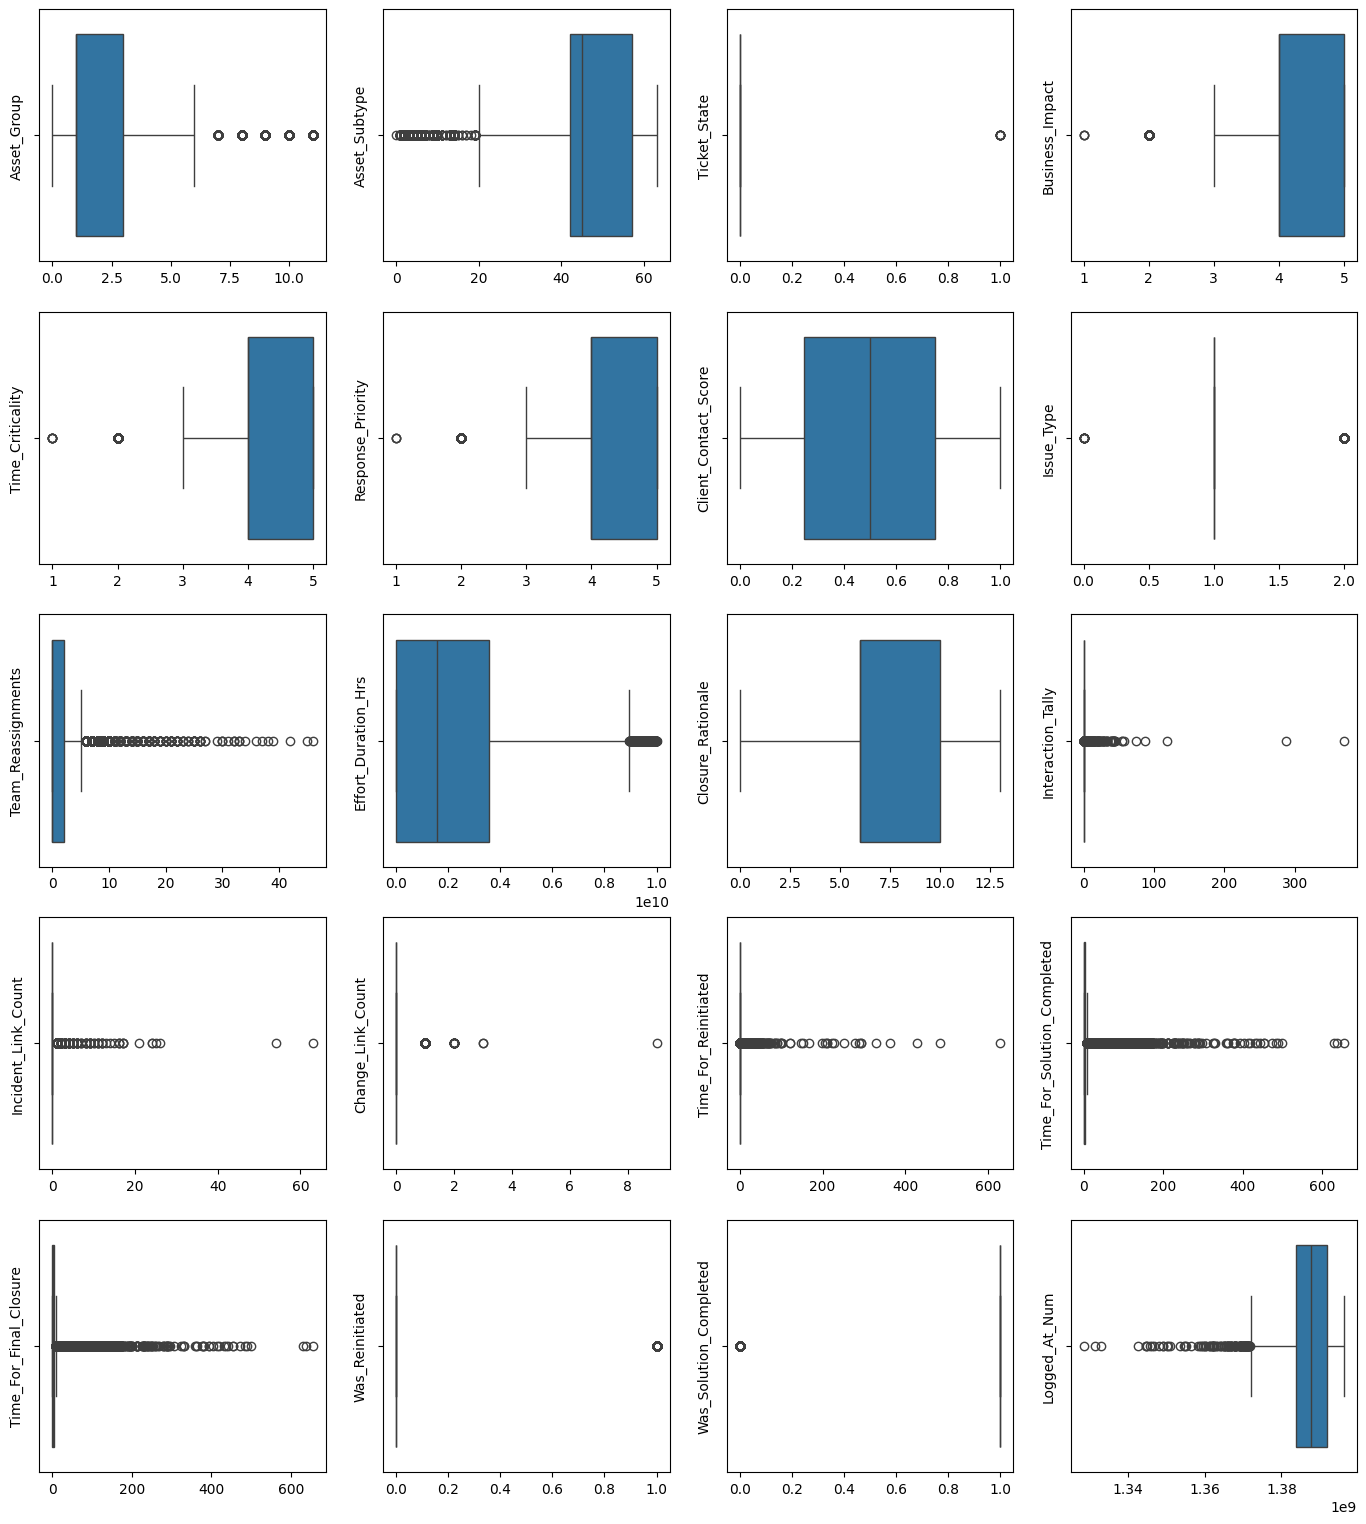

In [67]:
num_cols = desk_data.select_dtypes(include=['number']).columns

plt.figure(figsize=(17, 19))
for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=desk_data[col])
    plt.xlabel('')
    plt.ylabel(col)

plt.show()

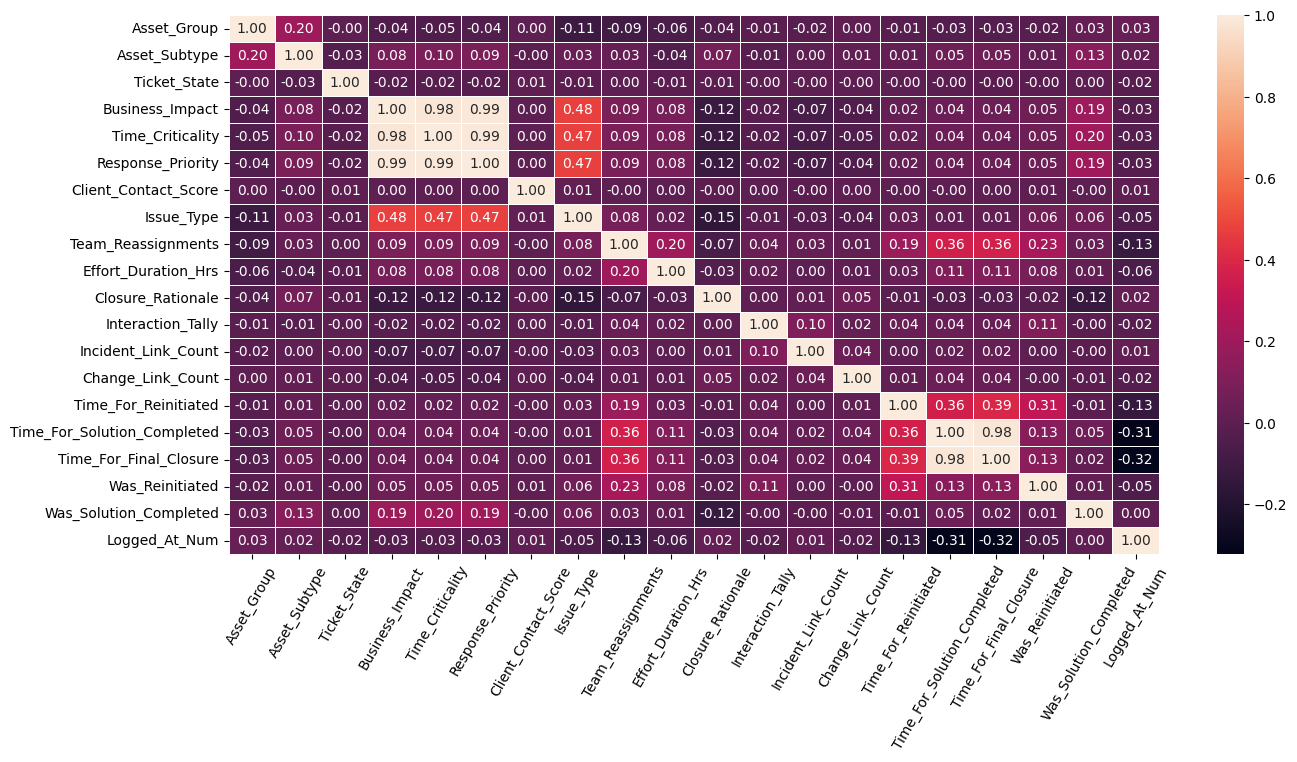

In [68]:
plt.figure(figsize=(15, 7))
sns.heatmap(desk_data[num_cols].corr(), annot=True, fmt=".2f", linewidths=0.5)
plt.xticks(rotation=60)
plt.show()

In [69]:
for col in desk_data.columns:
    print(desk_data[col].value_counts(dropna=False), end='\n\n')

Asset_Group
1.0     32899
11.0     7782
3.0      3643
10.0      703
6.0       442
9.0       333
4.0       214
5.0       212
8.0       152
7.0       107
2.0         5
0.0         2
Name: count, dtype: int64

Asset_Subtype
45.0    18810
57.0    15311
10.0     3876
21.0     1921
42.0     1199
        ...  
59.0        1
56.0        1
39.0        1
33.0        1
38.0        1
Name: count, Length: 64, dtype: int64

Ticket_State
0.0    46485
1.0        9
Name: count, dtype: int64

Business_Impact
4.0    22571
5.0    16681
3.0     6554
2.0      685
1.0        3
Name: count, dtype: int64

Time_Criticality
4.0    22561
5.0    16719
3.0     6520
2.0      688
1.0        6
Name: count, dtype: int64

Response_Priority
4.0    22730
5.0    16426
3.0     6645
2.0      690
1.0        3
Name: count, dtype: int64

Client_Contact_Score
0.902320    1
0.601292    1
0.415050    1
0.517551    1
0.642927    1
           ..
0.860255    1
0.151630    1
0.440613    1
0.701705    1
0.025310    1
Name: count, Lengt

In [70]:
desk_data[cat_cols] = desk_data[cat_cols].astype('str')

# 1. High Priority Ticket Prediction

Build predictive models to identify tickets that are likely to escalate into Priority 1 or 2 incidents, allowing teams to act proactively and minimize impact.

- Creating a binary label *High_Priority* to specify if priority is high or low
- Using *Response_Priority* labels 1.0 and 2.0 as high priority
- *High_Priority* is the target column for Binary Classification
- Using the Logits from neural network to find the likelihood (probability) of ticket going into high priority

In [71]:
# Dropping Date cols
tic_data = desk_data.drop(columns=["Logged_At", "Reinitiated_At", "Solution_Completed_At", "Final_Closure_At"])

In [72]:
# Creating new col from Response_Priority where label is (1, 2) as 1 or 0
tic_data["High_Priority"] = tic_data["Response_Priority"].isin([1, 2]).astype('float')
tic_data = tic_data.drop(columns=["Response_Priority"])

In [73]:
tic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Asset_Group                  46494 non-null  object 
 1   Asset_Subtype                46494 non-null  object 
 2   Ticket_State                 46494 non-null  object 
 3   Business_Impact              46494 non-null  float64
 4   Time_Criticality             46494 non-null  float64
 5   Client_Contact_Score         46494 non-null  float64
 6   Issue_Type                   46494 non-null  object 
 7   Team_Reassignments           46494 non-null  float64
 8   Effort_Duration_Hrs          46494 non-null  float64
 9   Closure_Rationale            46494 non-null  object 
 10  Interaction_Tally            46494 non-null  float64
 11  Incident_Link_Count          46494 non-null  float64
 12  Change_Link_Count            46494 non-null  float64
 13  Time_For_Reiniti

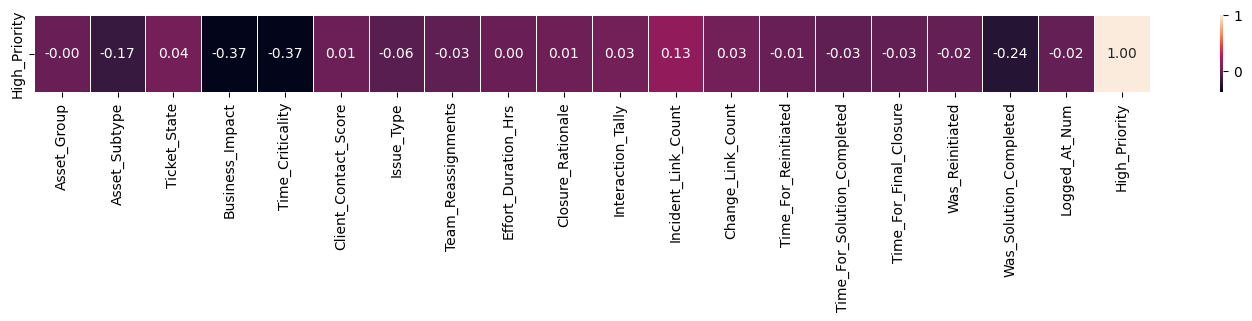

In [74]:
# Correlation heat map of high priority and all cols
plt.figure(figsize=(18, 1))
sns.heatmap(tic_data.corr().iloc[-1:,:], annot=True, fmt=".2f", linewidths=0.5)
plt.show()

In [75]:
# feature importance of high priority and all cols
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X = tic_data.drop(columns=["High_Priority"])
y = tic_data["High_Priority"]
rf_model.fit(X, y)
feature_imp = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feature_imp

,Importance
Business_Impact,0.454430
Time_Criticality,0.426024
Asset_Subtype,0.061024
Time_For_Solution_Completed,0.014192
Was_Solution_Completed,0.011540
Asset_Group,0.007118
Time_For_Final_Closure,0.005726
Incident_Link_Count,0.004254
Effort_Duration_Hrs,0.004140
Interaction_Tally,0.002893


In [76]:
# Dropping low value cols
tic_data.drop(
    columns=['Asset_Subtype','Ticket_State', 'Interaction_Tally','Incident_Link_Count','Change_Link_Count'],
    inplace=True
    )

### Scaling and encoding data

In [77]:
# One hot encoding categorical and standard scaling numeric cols
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

cat_cols = tic_data.select_dtypes('object').columns
num_cols = ["Business_Impact", "Time_Criticality", "Client_Contact_Score",
            "Team_Reassignments", "Effort_Duration_Hrs", "Time_For_Reinitiated",
            "Time_For_Solution_Completed", "Time_For_Final_Closure",
            "Logged_At_Num"]

tic_cat = pd.DataFrame(
    data=ohe.fit_transform(tic_data[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=tic_data.index
    )
tic_num = pd.DataFrame(
    data=scaler.fit_transform(tic_data[num_cols]),
    columns=num_cols,
    index=tic_data.index
    )

tic_data = pd.concat([tic_cat, tic_num, tic_data[["Was_Reinitiated", "Was_Solution_Completed", "High_Priority"]]], axis=1)
tic_data

,Asset_Group_0.0,Asset_Group_1.0,Asset_Group_10.0,Asset_Group_11.0,Asset_Group_2.0,Asset_Group_3.0,Asset_Group_4.0,Asset_Group_5.0,Asset_Group_6.0,Asset_Group_7.0,...,Client_Contact_Score,Team_Reassignments,Effort_Duration_Hrs,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Logged_At_Num,Was_Reinitiated,Was_Solution_Completed,High_Priority
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.352031,10.950774,0.617151,-0.069374,34.089191,33.518344,-12.235069,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.293164,14.033335,0.807655,90.480950,33.650667,33.087037,-11.593127,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061929,0.822359,1.000224,-0.069374,35.009845,34.423769,-11.293080,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.496266,5.226018,0.794660,-0.069374,25.843922,25.409425,-9.337153,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.534942,0.381993,0.424797,-0.069374,24.240015,23.832049,-8.910871,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46489,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.927661,-0.498738,-0.909612,-0.069374,-0.269163,-0.271715,1.729392,0.0,1.0,0.0
46490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.058261,-0.498738,-0.909612,-0.069374,-0.268415,-0.270980,1.728404,0.0,1.0,0.0
46491,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.447346,-0.498738,-0.909612,-0.069374,-0.269238,-0.271789,1.728713,0.0,1.0,0.0
46492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.698410,-0.498738,-0.909612,-0.069374,-0.269125,-0.271679,1.728800,0.0,1.0,0.0


In [78]:
tic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Asset_Group_0.0              46494 non-null  float64
 1   Asset_Group_1.0              46494 non-null  float64
 2   Asset_Group_10.0             46494 non-null  float64
 3   Asset_Group_11.0             46494 non-null  float64
 4   Asset_Group_2.0              46494 non-null  float64
 5   Asset_Group_3.0              46494 non-null  float64
 6   Asset_Group_4.0              46494 non-null  float64
 7   Asset_Group_5.0              46494 non-null  float64
 8   Asset_Group_6.0              46494 non-null  float64
 9   Asset_Group_7.0              46494 non-null  float64
 10  Asset_Group_8.0              46494 non-null  float64
 11  Asset_Group_9.0              46494 non-null  float64
 12  Issue_Type_0.0               46494 non-null  float64
 13  Issue_Type_1.0  

In [79]:
# High_Priority is target col
X = tic_data.drop(columns=["High_Priority"])
y = tic_data["High_Priority"]

X.shape, y.shape

((46494, 40), (46494,))

In [80]:
y.value_counts()

,count
High_Priority,
0.0,45801
1.0,693


### Splitting data

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37195, 40), (9299, 40), (37195,), (9299,))

In [83]:
# Creating tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [84]:
# Dataset and data loaders with 32 batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
# Neural network with 32 neuron hidden layer
class TicketPriorityClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TicketPriorityClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.network(x)

In [86]:
# Increasing positive class weight due to imbalance
input_dim, output_dim = X_train.shape[1], 1
number_negative = tic_data["High_Priority"].value_counts()[0]
number_positive = tic_data["High_Priority"].value_counts()[1]

ticket_priority_classifier = TicketPriorityClassifier(input_dim, output_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([number_negative / number_positive], device=device))
optimizer = optim.Adam(ticket_priority_classifier.parameters(), lr=0.001)

### Training loop

In [87]:
# Training loop with validation loss, early stopping and overfitting monitoring
epochs = 10
steps = 2
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
    ticket_priority_classifier.train()
    train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ticket_priority_classifier(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    ticket_priority_classifier.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ticket_priority_classifier(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(ticket_priority_classifier.state_dict(), 'ticket_priority_classifier.pth')
    else:
        counter += 1

    # Early Stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
        ticket_priority_classifier.load_state_dict(torch.load('ticket_priority_classifier.pth'))
        break

    # Overfitting
    if train_loss < val_loss and counter >= patience:
        print(f"Possible Overfitting at Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")
        ticket_priority_classifier.load_state_dict(torch.load('ticket_priority_classifier.pth'))
        break

    if (epoch+1) % steps == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

Epoch [2/10], Train Loss: 0.0182, Val Loss: 0.0082
Epoch [4/10], Train Loss: 0.0045, Val Loss: 0.0036
Epoch [6/10], Train Loss: 0.0018, Val Loss: 0.0009
Epoch [8/10], Train Loss: 0.0009, Val Loss: 0.0003
Epoch [10/10], Train Loss: 0.0005, Val Loss: 0.0003


In [88]:
# Evaluating model performance
ticket_priority_classifier.eval()
y_pred = []
y_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(ticket_priority_classifier(inputs))
        y_pred.extend((outputs > 0.5).cpu().numpy())
        y_proba.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9172
         1.0       1.00      1.00      1.00       127

    accuracy                           1.00      9299
   macro avg       1.00      1.00      1.00      9299
weighted avg       1.00      1.00      1.00      9299

Confusion Matrix:
 [[9172    0]
 [   0  127]]
ROC-AUC Score: 1.0


## An demostration High Priority likelihood and prediction

In [89]:
results_idx = pd.concat([y_test[y_test == 1].sample(n=2, random_state=42),
               y_test[y_test == 0].sample(n=3, random_state=42)]).index
high_priority_results = desk_data.drop(columns=date_cols).iloc[results_idx]

test = y_test.reset_index()
positions = []
for idx in results_idx:
    positions.append(test[test["index"] == idx].index[0])

high_priority_results["High_Priority_Prob"] = y_proba[positions].round(5)
high_priority_results["High_Priority"] = y_pred[positions]
high_priority_results

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Effort_Duration_Hrs,...,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num,High_Priority_Prob,High_Priority
45031,11.0,45.0,0.0,2.0,2.0,2.0,0.726332,1.0,0.0,1.663889e-01,...,0.0,0.0,0.0,0.006944,0.006944,0.0,1.0,1.395662e+09,0.99996,True
4665,3.0,2.0,0.0,2.0,2.0,2.0,0.290420,1.0,1.0,2.397500e+01,...,0.0,0.0,0.0,0.100000,0.100000,0.0,1.0,1.381502e+09,1.00000,True
17636,1.0,45.0,0.0,5.0,5.0,5.0,0.870643,1.0,4.0,8.254722e+09,...,0.0,0.0,0.0,2.906250,2.906250,0.0,1.0,1.385719e+09,0.00000,False
25035,10.0,41.0,0.0,5.0,5.0,5.0,0.640318,1.0,3.0,4.915556e+09,...,0.0,0.0,0.0,2.767361,2.767361,0.0,1.0,1.388769e+09,0.00000,False
24263,1.0,45.0,0.0,5.0,5.0,5.0,0.031810,2.0,1.0,3.391667e+09,...,0.0,0.0,0.0,6.100694,6.100694,0.0,1.0,1.388479e+09,0.00000,False


# 2. Incident volume forecasting

Use historical time-based data to forecast ticket volumes
quarterly and annually, supporting better resource planning and capacity management.

- Creating *Quarterly_vol* col for no.of tickets logged in that quarter using *Logged_At*
- Creating *Yearly_vol* col for no.of tickets logged in that year using *Logged_At*
- Using *Quarterly_vol* and *Yearly_vol* as target cols

In [90]:
# Dropping date cols except Logged_At
vol_data = desk_data.drop(columns=['Reinitiated_At','Solution_Completed_At', 'Final_Closure_At'])

In [91]:
# Calculating Quarterly logged tickets
vol_data['Quarterly_vol'] = vol_data['Logged_At'].dt.to_period('Q')
quarterly_counts = vol_data.groupby('Quarterly_vol').size()

quarterly_counts.index = quarterly_counts.index.astype(str)

vol_data["Quarterly_vol"] = vol_data["Quarterly_vol"].astype('str').map(quarterly_counts.to_dict())
quarterly_counts


,0
Quarterly_vol,
2012Q1,3
2012Q3,8
2012Q4,10
2013Q1,24
2013Q2,82
2013Q3,1019
2013Q4,23404
2014Q1,21944


In [92]:
# Calculating Yearly logged tickets
vol_data['Yearly_vol'] = vol_data['Logged_At'].dt.year
annual_counts = vol_data.groupby('Yearly_vol').size()

annual_counts.index = annual_counts.index.astype(str)

vol_data["Yearly_vol"] = vol_data["Yearly_vol"].astype('str').map(annual_counts.to_dict())

vol_data.drop(columns=["Logged_At"], inplace=True)
annual_counts

,0
Yearly_vol,
2012,21
2013,24529
2014,21944


In [93]:
vol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Asset_Group                  46494 non-null  object 
 1   Asset_Subtype                46494 non-null  object 
 2   Ticket_State                 46494 non-null  object 
 3   Business_Impact              46494 non-null  float64
 4   Time_Criticality             46494 non-null  float64
 5   Response_Priority            46494 non-null  float64
 6   Client_Contact_Score         46494 non-null  float64
 7   Issue_Type                   46494 non-null  object 
 8   Team_Reassignments           46494 non-null  float64
 9   Effort_Duration_Hrs          46494 non-null  float64
 10  Closure_Rationale            46494 non-null  object 
 11  Interaction_Tally            46494 non-null  float64
 12  Incident_Link_Count          46494 non-null  float64
 13  Change_Link_Coun

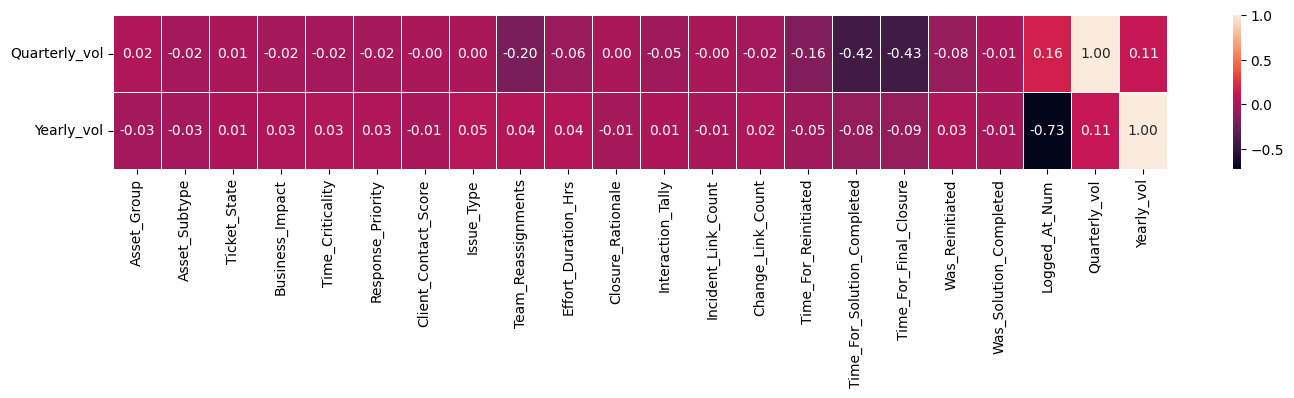

In [94]:
# Correlation heatmap of Quarterly and yearly cols
plt.figure(figsize=(17, 2))
sns.heatmap(vol_data.corr().iloc[-2:,:], annot=True, fmt=".2f", linewidth=0.5)
plt.show()

In [95]:
# Feature importance of Quarterly and Yearly cols
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

X = vol_data.drop(columns=["Quarterly_vol", "Yearly_vol"])
y = vol_data["Quarterly_vol"]
rf_model1.fit(X, y)

y = vol_data['Yearly_vol']
rf_model2.fit(X, y)

feature_importance = pd.DataFrame(
    data={"Quarterly_imp":rf_model1.feature_importances_, "Yearly_imp": rf_model2.feature_importances_},
    index=X.columns
    )

feature_importance['Quarterly_imp'] = feature_importance['Quarterly_imp'].round(5)
feature_importance['Yearly_imp'] = feature_importance['Yearly_imp'].round(5)
feature_importance

,Quarterly_imp,Yearly_imp
Asset_Group,0.0,0.00000
Asset_Subtype,0.0,0.00000
Ticket_State,0.0,0.00000
Business_Impact,0.0,0.00000
Time_Criticality,0.0,0.00000
Response_Priority,0.0,0.00000
Client_Contact_Score,0.0,0.00000
Issue_Type,0.0,0.00000
Team_Reassignments,0.0,0.00000
Effort_Duration_Hrs,0.0,0.00000


In [96]:
# Dropping low value cols
vol_data.drop(
    columns=["Asset_Subtype", "Ticket_State", "Interaction_Tally", "Incident_Link_Count", "Change_Link_Count"],
    inplace=True
)

In [97]:
vol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Asset_Group                  46494 non-null  object 
 1   Business_Impact              46494 non-null  float64
 2   Time_Criticality             46494 non-null  float64
 3   Response_Priority            46494 non-null  float64
 4   Client_Contact_Score         46494 non-null  float64
 5   Issue_Type                   46494 non-null  object 
 6   Team_Reassignments           46494 non-null  float64
 7   Effort_Duration_Hrs          46494 non-null  float64
 8   Closure_Rationale            46494 non-null  object 
 9   Time_For_Reinitiated         46494 non-null  float64
 10  Time_For_Solution_Completed  46494 non-null  float64
 11  Time_For_Final_Closure       46494 non-null  float64
 12  Was_Reinitiated              46494 non-null  float64
 13  Was_Solution_Com

### Scaling and encoding data

In [98]:
# One hot encoding categorical and standard scaling numeric cols
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

cat_cols = vol_data.select_dtypes('object').columns
num_cols = ["Business_Impact", "Time_Criticality", "Response_Priority", "Client_Contact_Score",
            "Team_Reassignments", "Effort_Duration_Hrs", "Time_For_Reinitiated",
            "Time_For_Solution_Completed", "Time_For_Final_Closure", "Logged_At_Num",
            "Quarterly_vol", "Yearly_vol"
            ]

vol_cat = pd.DataFrame(
    ohe.fit_transform(vol_data[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=vol_data.index
    )
vol_num = pd.DataFrame(
    scaler.fit_transform(vol_data[num_cols]),
    columns=num_cols,
    index=vol_data.index
    )

vol_data = pd.concat([vol_cat, vol_num, vol_data[["Was_Reinitiated", "Was_Solution_Completed"]]], axis=1)
vol_data

,Asset_Group_0.0,Asset_Group_1.0,Asset_Group_10.0,Asset_Group_11.0,Asset_Group_2.0,Asset_Group_3.0,Asset_Group_4.0,Asset_Group_5.0,Asset_Group_6.0,Asset_Group_7.0,...,Team_Reassignments,Effort_Duration_Hrs,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Logged_At_Num,Quarterly_vol,Yearly_vol,Was_Reinitiated,Was_Solution_Completed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.950774,0.617151,-0.069374,34.089191,33.518344,-12.235069,-6.414853,-16.844905,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.033335,0.807655,90.480950,33.650667,33.087037,-11.593127,-6.414853,-16.844905,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.822359,1.000224,-0.069374,35.009845,34.423769,-11.293080,-6.414853,-16.844905,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.226018,0.794660,-0.069374,25.843922,25.409425,-9.337153,-6.413405,-16.844905,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.381993,0.424797,-0.069374,24.240015,23.832049,-8.910871,-6.413405,-16.844905,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46489,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.498738,-0.909612,-0.069374,-0.269163,-0.271715,1.729392,-0.062691,-0.979767,0.0,1.0
46490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.498738,-0.909612,-0.069374,-0.268415,-0.270980,1.728404,-0.062691,-0.979767,0.0,1.0
46491,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.498738,-0.909612,-0.069374,-0.269238,-0.271789,1.728713,-0.062691,-0.979767,0.0,1.0
46492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.498738,-0.909612,-0.069374,-0.269125,-0.271679,1.728800,-0.062691,-0.979767,0.0,1.0


In [99]:
# Target cols are Quarterly_vol and Yearly_vol
X = vol_data.drop(columns=["Quarterly_vol", "Yearly_vol"])
y = vol_data[["Quarterly_vol", "Yearly_vol"]]

X.shape, y.shape

((46494, 41), (46494, 2))

### Splitting data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# Creating tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [102]:
# Creating datasets and data loaders with 32 batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [103]:
# Neural network with 3 hidden layers
class TicketVolumeForecaster(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TicketVolumeForecaster, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [104]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

ticket_volume_forecaster = TicketVolumeForecaster(input_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ticket_volume_forecaster.parameters(), lr=0.001)

### Training loop

In [105]:
epochs = 100
steps = 10
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
    ticket_volume_forecaster.train()
    train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ticket_volume_forecaster(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    ticket_volume_forecaster.eval()
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ticket_volume_forecaster(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(ticket_volume_forecaster.state_dict(), 'ticket_volume_forecaster.pth')
    else:
        counter += 1

    # Early Stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, Train loss: {train_loss/len(train_loader):.4f}, Val loss: {val_loss/len(test_loader):.4f}")
        ticket_volume_forecaster.load_state_dict(torch.load('ticket_volume_forecaster.pth'))
        break

    # Overfitting
    if train_loss < val_loss and counter >= patience:
        print(f"Possible Overfitting at Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")
        ticket_volume_forecaster.load_state_dict(torch.load('ticket_volume_forecaster.pth'))
        break

    if (epoch+1) % steps == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

Epoch [10/100], Train Loss: 0.1118, Val Loss: 0.1064
Epoch [20/100], Train Loss: 0.0866, Val Loss: 0.0878
Epoch [30/100], Train Loss: 0.0681, Val Loss: 0.1015
Early stopping at epoch 38, Train loss: 0.0677, Val loss: 0.0958


In [106]:
# Evaluating model performance
ticket_volume_forecaster.eval()
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ticket_volume_forecaster(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)
print("Quarterly Ticket Volume:")
print("Mean Squared Error:", mean_squared_error(y_test['Quarterly_vol'], y_pred[:,0]))
print("R^2 Score:", r2_score(y_test['Quarterly_vol'], y_pred[:,0]))

print("\nYearly Ticket Volume:")
print("Mean Squared Error:", mean_squared_error(y_test['Yearly_vol'], y_pred[:,1]))
print("R^2 Score:", r2_score(y_test['Yearly_vol'], y_pred[:,1]))

Quarterly Ticket Volume:
Mean Squared Error: 0.1464671670977897
R^2 Score: 0.8529586726727758

Yearly Ticket Volume:
Mean Squared Error: 0.02584404004127372
R^2 Score: 0.974017858520662


## Demostration of Quarterly and Yearly volume forecast

In [107]:
vol_results = desk_data.drop(columns=date_cols).iloc[X_test.head().index]

vol_results["Quarterly_vol"] = (y_pred[:5,0] * 13,723.9)[0] + 15498
vol_results["Yearly_vol"] = (y_pred[:5,1] * 10420.5886967) + 5811.75

vol_results

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Effort_Duration_Hrs,...,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num,Quarterly_vol,Yearly_vol
564,1.0,10.0,0.0,4.0,4.0,4.0,0.898548,1.0,0.0,5.849722e+09,...,0.0,0.0,0.0,8.936806,8.936806,0.0,1.0,1.379951e+09,15413.663086,13831.146484
501,11.0,57.0,0.0,4.0,4.0,4.0,0.983850,1.0,0.0,3.420133e+09,...,0.0,0.0,0.0,92.019444,92.020139,0.0,1.0,1.379588e+09,15429.054688,13284.016602
11879,1.0,10.0,0.0,4.0,4.0,4.0,0.736440,1.0,0.0,5.563889e+09,...,0.0,0.0,0.0,9.872222,9.872222,0.0,1.0,1.383910e+09,15502.223633,15100.228516
20867,11.0,57.0,0.0,4.0,4.0,4.0,0.704877,1.0,2.0,2.009944e+09,...,0.0,0.0,0.0,11.140278,11.140278,0.0,1.0,1.386848e+09,15502.439453,15214.051758
18585,1.0,57.0,0.0,4.0,5.0,4.0,0.235746,1.0,1.0,2.289611e+09,...,0.0,0.0,0.0,2.079167,2.079167,0.0,1.0,1.386147e+09,15502.539062,15158.872070


# 3. Ticket Classification

Develop classifiers to automatically assign appropriate priority levels and departments, reducing delays caused by misrouted or miscategorized tickets.

- Using Response_Priority and Asset_Group as target cols to assign priority levels and departments
- Oversampling Asset_Group and Response_Priority to balance the less no.of rows for few labels

In [108]:
# Dropping date cols
tic_data = desk_data.drop(columns=["Logged_At", "Reinitiated_At", "Solution_Completed_At", "Final_Closure_At"])

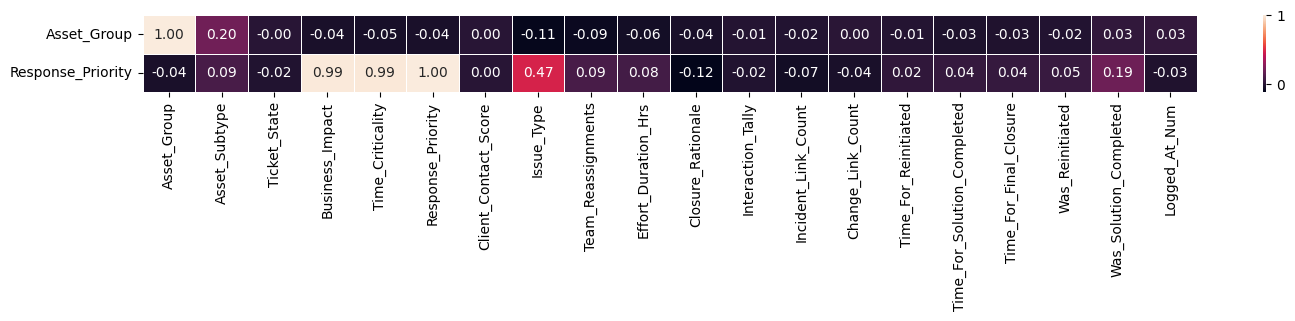

In [109]:
# Correlation heatmap
plt.figure(figsize=(17, 1))
sns.heatmap(tic_data.corr().loc[["Asset_Group", "Response_Priority"], :], annot=True, fmt=".2f", linewidths=0.5)
plt.show()

In [110]:
# Feature importances
rf_model1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42)

X = tic_data.drop(columns=["Asset_Group", "Response_Priority"])
y = tic_data["Asset_Group"]
rf_model1.fit(X, y)

y = tic_data['Response_Priority']
rf_model2.fit(X, y)

feature_importance = pd.DataFrame(
    data={"Asset_imp":rf_model1.feature_importances_, "Response_imp": rf_model2.feature_importances_},
    index=X.columns
    )
feature_importance['Asset_imp'] = feature_importance['Asset_imp'].round(5)
feature_importance['Response_imp'] = feature_importance['Response_imp'].round(5)
feature_importance

,Asset_imp,Response_imp
Asset_Subtype,0.33382,0.02542
Ticket_State,0.00011,0.00000
Business_Impact,0.02865,0.49020
Time_Criticality,0.03334,0.39304
Client_Contact_Score,0.08300,0.00113
Issue_Type,0.01743,0.05727
Team_Reassignments,0.02579,0.00138
Effort_Duration_Hrs,0.09210,0.00677
Closure_Rationale,0.10157,0.00561
Interaction_Tally,0.00544,0.00049


In [111]:
# Dropping low value columns
tic_data.drop(
    columns=["Ticket_State", "Interaction_Tally", "Incident_Link_Count", "Change_Link_Count",
             "Time_For_Reinitiated", "Time_For_Solution_Completed", "Time_For_Final_Closure"]
    ,inplace=True
    )

In [112]:
tic_data[tic_data.select_dtypes('object').columns] = tic_data.select_dtypes('object').astype('float')

In [113]:
tic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46494 entries, 0 to 46493
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Asset_Group             46494 non-null  float64
 1   Asset_Subtype           46494 non-null  float64
 2   Business_Impact         46494 non-null  float64
 3   Time_Criticality        46494 non-null  float64
 4   Response_Priority       46494 non-null  float64
 5   Client_Contact_Score    46494 non-null  float64
 6   Issue_Type              46494 non-null  float64
 7   Team_Reassignments      46494 non-null  float64
 8   Effort_Duration_Hrs     46494 non-null  float64
 9   Closure_Rationale       46494 non-null  float64
 10  Was_Reinitiated         46494 non-null  float64
 11  Was_Solution_Completed  46494 non-null  float64
 12  Logged_At_Num           46494 non-null  float64
dtypes: float64(13)
memory usage: 4.6 MB


### Oversampling data

In [114]:
tic_data["Response_Priority"].value_counts()

,count
Response_Priority,
4.0,22730
5.0,16426
3.0,6645
2.0,690
1.0,3


In [115]:
tic_data["Asset_Group"].value_counts()

,count
Asset_Group,
1.0,32899
11.0,7782
3.0,3643
10.0,703
6.0,442
9.0,333
4.0,214
5.0,212
8.0,152


In [116]:
# Undersampling 5 and 4 labels in Response_Priority to 8000
tic_data = pd.concat(
    [(tic_data[tic_data["Response_Priority"] == 5]).sample(n=8000, random_state=42),
     (tic_data[tic_data["Response_Priority"] == 4]).sample(n=8000, random_state=42),
     (tic_data[tic_data["Response_Priority"].isin([1,2,3])]),
     (tic_data[tic_data["Response_Priority"] == 1])],
)

In [117]:
# Oversampling Response_Priority using SMOTE
X_smote = tic_data.drop(columns=["Response_Priority"])
y_smote = tic_data["Response_Priority"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)
tic_data = pd.concat([X_resampled, y_resampled], axis=1)

print("Shape of data before SMOTE:", X_smote.shape)
print("Shape of data after SMOTE:", X_resampled.shape)
print("\nValue counts of target before SMOTE:\n", y_smote.value_counts())
print("\nValue counts of target after SMOTE:\n", y_resampled.value_counts())

Shape of data before SMOTE: (23341, 12)
Shape of data after SMOTE: (40000, 12)

Value counts of target before SMOTE:
 Response_Priority
5.0    8000
4.0    8000
3.0    6645
2.0     690
1.0       6
Name: count, dtype: int64

Value counts of target after SMOTE:
 Response_Priority
5.0    8000
4.0    8000
3.0    8000
2.0    8000
1.0    8000
Name: count, dtype: int64


In [118]:
# Rounding categorical cols
round_cols = ["Asset_Group", "Asset_Subtype", "Business_Impact",
              "Time_Criticality", "Issue_Type", "Team_Reassignments",
              "Closure_Rationale", "Was_Reinitiated", "Was_Solution_Completed"]
for col in round_cols:
    tic_data[col] = tic_data[col].apply(round).astype('float')

In [119]:
for col in round_cols:
    print(tic_data[col].value_counts())

Asset_Group
1.0     19458
11.0     6706
3.0      6432
2.0      1646
6.0      1011
10.0      943
4.0       917
5.0       753
9.0       744
8.0       697
7.0       685
0.0         8
Name: count, dtype: int64
Asset_Subtype
45.0    11524
57.0     9960
2.0      3902
10.0     2200
21.0     1006
        ...  
61.0       16
60.0       10
62.0        4
0.0         1
63.0        1
Name: count, Length: 63, dtype: int64
Business_Impact
5.0    8096
4.0    8026
1.0    8000
2.0    7949
3.0    7929
Name: count, dtype: int64
Time_Criticality
5.0    8110
4.0    8063
1.0    8023
2.0    7930
3.0    7874
Name: count, dtype: int64
Issue_Type
1.0    35465
2.0     4528
0.0        7
Name: count, dtype: int64
Team_Reassignments
0.0     24253
1.0      8947
2.0      3249
3.0      1233
4.0       915
5.0       381
6.0       325
7.0       174
8.0       132
9.0        91
10.0       71
11.0       49
12.0       32
13.0       27
14.0       25
15.0       24
16.0       13
17.0        9
18.0        9
21.0        7
19.0    

In [120]:
# Undersampling Asset_Group 1, 11, 3 labels to 3000 rows
tic_data = pd.concat(
    [(tic_data[tic_data["Asset_Group"] == 1]).sample(n=3000, random_state=42),
     (tic_data[tic_data["Asset_Group"] == 11]).sample(n=3000, random_state=42),
     (tic_data[tic_data["Asset_Group"] == 3]).sample(n=3000, random_state=42),
     (tic_data[~tic_data["Asset_Group"].isin([1,11,3])])]
)

In [121]:
# Oversampling Asset_Group column using SMOTE
X_smote = tic_data.drop(columns=["Asset_Group"])
y_smote = tic_data["Asset_Group"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)
tic_data = pd.concat([X_resampled, y_resampled], axis=1)

print("Shape of data before SMOTE:", X_smote.shape)
print("Shape of data after SMOTE:", X_resampled.shape)
print("\nValue counts of target before SMOTE:\n", y_smote.value_counts())
print("\nValue counts of target after SMOTE:\n", y_resampled.value_counts())

Shape of data before SMOTE: (16404, 12)
Shape of data after SMOTE: (36000, 12)

Value counts of target before SMOTE:
 Asset_Group
1.0     3000
11.0    3000
3.0     3000
2.0     1646
6.0     1011
10.0     943
4.0      917
5.0      753
9.0      744
8.0      697
7.0      685
0.0        8
Name: count, dtype: int64

Value counts of target after SMOTE:
 Asset_Group
1.0     3000
11.0    3000
3.0     3000
6.0     3000
9.0     3000
10.0    3000
5.0     3000
8.0     3000
4.0     3000
7.0     3000
2.0     3000
0.0     3000
Name: count, dtype: int64


In [122]:
# Rounding categorical columns
round_cols = ["Asset_Subtype", "Business_Impact", "Time_Criticality",
              "Response_Priority", "Issue_Type", "Team_Reassignments",
              "Closure_Rationale", "Was_Reinitiated", "Was_Solution_Completed"]
for col in round_cols:
    tic_data[col] = tic_data[col].apply(round).astype('float')

In [123]:
for col in round_cols:
    print(tic_data[col].value_counts())

Asset_Subtype
57.0    8173
45.0    2440
2.0     1861
49.0    1689
48.0    1044
        ... 
1.0       51
61.0       7
60.0       5
62.0       2
0.0        1
Name: count, Length: 62, dtype: int64
Business_Impact
1.0    13646
2.0    11203
3.0     5670
4.0     3108
5.0     2373
Name: count, dtype: int64
Time_Criticality
1.0    13655
2.0    11170
3.0     5722
4.0     3122
5.0     2331
Name: count, dtype: int64
Response_Priority
1.0    13647
2.0    11242
3.0     5737
4.0     3077
5.0     2297
Name: count, dtype: int64
Issue_Type
1.0    34577
2.0     1404
0.0       19
Name: count, dtype: int64
Team_Reassignments
0.0     23636
1.0      9180
2.0      1700
3.0       669
4.0       412
5.0       151
6.0        87
7.0        53
8.0        27
9.0        24
11.0       11
10.0        9
15.0        7
13.0        7
14.0        4
12.0        4
17.0        4
19.0        3
18.0        2
16.0        2
32.0        2
21.0        1
46.0        1
31.0        1
25.0        1
20.0        1
22.0        1
Name: co

### Scaling and encoding data

In [124]:
# One hot encoding categorical and standard scaling numeric cols
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

cat_cols = ["Issue_Type", "Closure_Rationale"]
num_cols = ["Business_Impact", "Time_Criticality", "Client_Contact_Score",
            "Team_Reassignments", "Effort_Duration_Hrs", "Logged_At_Num"]

tic_cat = pd.DataFrame(
        data=ohe.fit_transform(tic_data[cat_cols]),
        columns=ohe.get_feature_names_out(cat_cols),
        index=tic_data.index
    )
tic_num = pd.DataFrame(
        data=scaler.fit_transform(tic_data[num_cols]),
        columns=num_cols,
        index=tic_data.index
    )

tic_data = pd.concat([tic_cat, tic_num, tic_data[["Asset_Subtype", "Response_Priority", "Asset_Group"]]], axis=1)
tic_data

,Issue_Type_0.0,Issue_Type_1.0,Issue_Type_2.0,Closure_Rationale_0.0,Closure_Rationale_1.0,Closure_Rationale_2.0,Closure_Rationale_3.0,Closure_Rationale_4.0,Closure_Rationale_5.0,Closure_Rationale_6.0,...,Closure_Rationale_13.0,Business_Impact,Time_Criticality,Client_Contact_Score,Team_Reassignments,Effort_Duration_Hrs,Logged_At_Num,Asset_Subtype,Response_Priority,Asset_Group
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.706107,0.709035,-0.734495,-0.461591,-0.944606,-2.182599,45.0,3.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.706107,0.709035,-1.825371,-0.461591,0.487011,0.493247,45.0,3.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.535710,1.540586,0.514089,-0.461591,-0.137750,0.443872,57.0,4.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,-0.123496,-0.122515,0.315458,-0.461591,-0.944606,-0.959435,10.0,2.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.706107,0.709035,1.215876,0.401734,0.281870,-2.114183,45.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.535710,1.540586,2.203579,-0.461591,0.692389,-0.727425,41.0,4.0,10.0
35996,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.953099,-0.954065,-1.537751,-0.461591,0.533649,0.491584,46.0,1.0,10.0
35997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.953099,-0.954065,-1.476051,-0.461591,0.497339,0.496076,47.0,1.0,10.0
35998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.365313,2.372136,-1.307210,1.265059,2.219051,1.073084,43.0,5.0,10.0


In [125]:
# Response_Priority and Asset_Group as target cols
X = tic_data.drop(columns=["Response_Priority", "Asset_Group"])
y = tic_data[["Response_Priority", "Asset_Group"]]

In [126]:
# Making Response_Priority labels from (1 to 5) to (0 to 4) for neural network
y["Response_Priority"] = y["Response_Priority"] - 1

### Splitting data

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28800, 24), (7200, 24), (28800, 2), (7200, 2))

In [129]:
# Dataset class to split response and asset cols
class TicketDataset(Dataset):
    def __init__(self, X, y):
        super(TicketDataset, self).__init__()
        self.X = X
        self.y_response = y[:,-2]
        self.y_asset = y[:,-1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], (self.y_response[idx], self.y_asset[idx])

In [130]:
# Creating tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

In [131]:
# Creating Dataset and Data loader
train_dataset = TicketDataset(X_train_tensor, y_train_tensor)
test_dataset = TicketDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [132]:
# neural network for Response_Priority with 2 hidden layers
class TicketResponseClassifier(nn.Module):
    def __init__(self, input_dim, response_classes):
        super(TicketResponseClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, response_classes)
        )

    def forward(self, x):
        return self.network(x)

In [133]:
# neural network for Asset_Group with 2 hidden layers
class TicketAssetClassifier(nn.Module):
    def __init__(self, input_dim, asset_classes):
        super(TicketAssetClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, asset_classes)
        )

    def forward(self, x):
        return self.network(x)

In [134]:
input_dim, response_classes, asset_classes = X.shape[1], y['Response_Priority'].nunique(), y['Asset_Group'].nunique()

ticket_response_classifier = TicketResponseClassifier(input_dim, response_classes).to(device)
ticket_asset_classifier = TicketAssetClassifier(input_dim, asset_classes).to(device)

response_criterion = nn.CrossEntropyLoss()
asset_criterion = nn.CrossEntropyLoss()

response_optimizer = optim.Adam(ticket_response_classifier.parameters(), lr=0.001)
asset_optimizer = optim.Adam(ticket_asset_classifier.parameters(), lr=0.001)

### Training loop

In [135]:
epochs = 10
steps = 2
patience = 5
best_val_loss = float('inf')
counter = 0

print("Response Priority Training:")
for epoch in range(epochs):
    ticket_response_classifier.train()
    train_loss = 0

    for inputs, (response_labels, asset_labels) in train_loader:
        response_outputs = ticket_response_classifier(inputs)
        response_loss = response_criterion(response_outputs, response_labels)

        response_optimizer.zero_grad()
        response_loss.backward()
        response_optimizer.step()
        train_loss += response_loss.item()

    ticket_response_classifier.eval()
    test_loss = 0

    for inputs, (response_labels, asset_labels) in test_loader:
        response_outputs = ticket_response_classifier(inputs)
        response_loss = response_criterion(response_outputs, response_labels)
        test_loss += response_loss.item()

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        torch.save(ticket_response_classifier.state_dict(), 'ticket_response_classifier.pth')
    else:
        counter += 1

    # Early Stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, Train loss: {train_loss/len(train_loader):.4f}, Val loss: {test_loss/len(test_loader):.4f}")
        ticket_response_classifier.load_state_dict(torch.load('ticket_response_classifier.pth'))
        break

    # Overfitting
    if test_loss < train_loss and counter >= patience:
        print(f"Possible Overfitting at Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")
        ticket_response_classifier.load_state_dict(torch.load('ticket_response_classifier.pth'))
        break

    if (epoch+1) % steps == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")

epochs = 100
steps = 10
patience = 5
best_val_loss = float('inf')
counter = 0

print("\nAsset Group Training:")
for epoch in range(epochs):
    ticket_asset_classifier.train()
    train_loss = 0

    for inputs, (response_labels, asset_labels) in train_loader:
        asset_outputs = ticket_asset_classifier(inputs)
        asset_loss = asset_criterion(asset_outputs, asset_labels)

        asset_optimizer.zero_grad()
        asset_loss.backward()
        asset_optimizer.step()
        train_loss += asset_loss.item()

    ticket_asset_classifier.eval()
    test_loss = 0

    for inputs, (response_labels, asset_labels) in test_loader:
        asset_outputs = ticket_asset_classifier(inputs)
        asset_loss = asset_criterion(asset_outputs, asset_labels)
        test_loss += asset_loss.item()

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        torch.save(ticket_asset_classifier.state_dict(), 'ticket_asset_classifier.pth')
    else:
        counter += 1

    # Early Stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, Train loss: {train_loss/len(train_loader):.4f}, Val loss: {test_loss/len(test_loader):.4f}")
        ticket_asset_classifier.load_state_dict(torch.load('ticket_asset_classifier.pth'))
        break

    # Overfitting
    if test_loss < train_loss and counter >= patience:
        print(f"Possible Overfitting at Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")
        ticket_asset_classifier.load_state_dict(torch.load('ticket_asset_classifier.pth'))
        break

    if (epoch+1) % steps == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")

Response Priority Training:
Epoch [2/10], Train Loss: 0.0154, Val Loss: 0.0062
Epoch [4/10], Train Loss: 0.0048, Val Loss: 0.0021
Epoch [6/10], Train Loss: 0.0020, Val Loss: 0.0064
Epoch [8/10], Train Loss: 0.0026, Val Loss: 0.0004
Epoch [10/10], Train Loss: 0.0006, Val Loss: 0.0002

Asset Group Training:
Epoch [10/100], Train Loss: 0.8988, Val Loss: 0.9228
Epoch [20/100], Train Loss: 0.7636, Val Loss: 0.7993
Epoch [30/100], Train Loss: 0.7043, Val Loss: 0.7572
Epoch [40/100], Train Loss: 0.6699, Val Loss: 0.7230
Epoch [50/100], Train Loss: 0.6491, Val Loss: 0.7086
Early stopping at epoch 56, Train loss: 0.6397, Val loss: 0.7291


In [136]:
# Evaluating model performance
ticket_response_classifier.eval()
ticket_asset_classifier.eval()

response_pred = []
response_targets = []
asset_pred = []
asset_targets = []

with torch.no_grad():
    for inputs, (response_labels, asset_labels) in test_loader:
        response_outputs = ticket_response_classifier(inputs)
        asset_outputs = ticket_asset_classifier(inputs)

        response_pred.append(response_outputs.cpu().numpy())
        asset_pred.append(asset_outputs.cpu().numpy())
        response_targets.append(response_labels.cpu().numpy())
        asset_targets.append(asset_labels.cpu().numpy())

response_pred = np.concatenate(response_pred, axis=0)
asset_pred = np.concatenate(asset_pred, axis=0)
response_targets = np.concatenate(response_targets, axis=0)
asset_targets = np.concatenate(asset_targets, axis=0)

response_pred.shape, asset_pred.shape, response_targets.shape, asset_targets.shape

((7200, 5), (7200, 12), (7200,), (7200,))

In [137]:
response_pred = np.argmax(response_pred, axis=1)
asset_pred = np.argmax(asset_pred, axis=1)

In [138]:
print(f"Response Priority Classification Report:\n{classification_report(response_targets, response_pred)}\n")

print(f"Asset Group Classification Report:\n{classification_report(asset_targets, asset_pred)}")

Response Priority Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2714
           1       1.00      1.00      1.00      2250
           2       1.00      1.00      1.00      1150
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00       473

    accuracy                           1.00      7200
   macro avg       1.00      1.00      1.00      7200
weighted avg       1.00      1.00      1.00      7200


Asset Group Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       577
           1       0.60      0.61      0.61       596
           2       0.65      0.72      0.68       595
           3       0.88      0.88      0.88       620
           4       0.81      0.79      0.80       604
           5       0.66      0.70      0.68       583
           6       0.81      0.69      0.75       562
 

### Demostration of priority and department prediction

In [139]:
priority_results = desk_data.drop(columns=date_cols).iloc[X_test.head().index]

priority_results["Response_Priority_pred"] = response_pred[:5]
priority_results["Asset_Group_pred"] = asset_pred[:5]
priority_results

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Effort_Duration_Hrs,...,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num,Response_Priority_pred,Asset_Group_pred
16461,1.0,45.0,0.0,3.0,3.0,3.0,0.477625,1.0,0.0,4.161111e-01,...,0.0,0.0,0.0,0.143056,0.143056,0.0,1.0,1.385458e+09,1,0
23579,1.0,45.0,0.0,4.0,4.0,4.0,0.057059,1.0,3.0,2.164722e+09,...,1.0,0.0,0.0,6.027083,6.027083,0.0,1.0,1.387876e+09,1,2
23640,1.0,45.0,0.0,5.0,5.0,5.0,0.790833,2.0,2.0,1.497056e+09,...,0.0,0.0,0.0,5.749306,5.749306,0.0,1.0,1.387896e+09,0,5
25635,1.0,45.0,0.0,5.0,5.0,5.0,0.703696,2.0,0.0,5.750000e-02,...,0.0,0.0,0.0,0.002083,0.002083,0.0,1.0,1.389086e+09,3,6
8840,1.0,45.0,0.0,5.0,5.0,5.0,0.399880,2.0,1.0,8.564722e+09,...,0.0,0.0,0.0,0.919444,0.919444,0.0,1.0,1.383045e+09,2,1


# RFC & Misconfig Risk Prediction

Predict the likelihood that a ticket will lead to a Request for Change (RFC) or result in a system misconfiguration, enabling smarter change control decisions.

- Creating new *RFC* col to specify if there is Change from *Change_Link_Count* col
- Binary label from *Change_Link_Count* if more than 0 as 1 else 0
- Using the Logits from neural network as likelihood (probability) for request for change

In [140]:
# Dropping date cols
rfc_data = desk_data.drop(columns=['Logged_At', 'Reinitiated_At', 'Solution_Completed_At', 'Final_Closure_At'])

In [141]:
cat_cols = rfc_data.select_dtypes('object').columns
rfc_data[cat_cols] = rfc_data[cat_cols].apply(le.fit_transform).astype('float')

In [142]:
# RFC col to specify if Request For Change has occured or not
rfc_data['RFC'] = rfc_data['Change_Link_Count'].apply(lambda x: 1.0 if x > 0 else 0.0)

<Axes: >

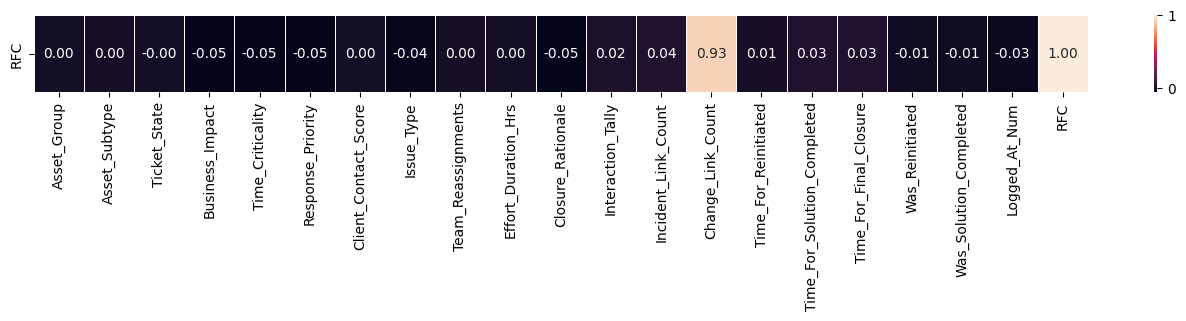

In [143]:
# Correlation heatmap
plt.figure(figsize=(17,1))
sns.heatmap(rfc_data.corr().iloc[-1:,:], annot=True, fmt=".2f", linewidths=0.5)

In [144]:
# Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

X = rfc_data.drop(columns=["RFC", "Change_Link_Count"])
y = rfc_data["RFC"]

rf_model.fit(X, y)
feature_importance = pd.DataFrame(
    data = {'feature': X.columns, 'importance': rf_model.feature_importances_}
).sort_values(by='importance', ascending=False)
feature_importance['importance'] = feature_importance['importance'].apply(lambda x: round(x, 5))
feature_importance

,feature,importance
18,Logged_At_Num,0.23863
15,Time_For_Final_Closure,0.14218
14,Time_For_Solution_Completed,0.13180
9,Effort_Duration_Hrs,0.12798
6,Client_Contact_Score,0.11561
1,Asset_Subtype,0.05305
8,Team_Reassignments,0.03765
10,Closure_Rationale,0.03560
0,Asset_Group,0.02834
11,Interaction_Tally,0.01754


### Scaling data

In [145]:
# Scaling numeric cols
scaler = StandardScaler()

num_cols = ["Business_Impact", "Time_Criticality", "Response_Priority",
            "Client_Contact_Score", "Team_Reassignments", "Effort_Duration_Hrs",
            "Interaction_Tally", "Incident_Link_Count","Time_For_Reinitiated",
            "Time_For_Solution_Completed","Time_For_Final_Closure", "Logged_At_Num"]

rfc_num = pd.DataFrame(
        data=scaler.fit_transform(rfc_data[num_cols]),
        columns=num_cols,
        index=rfc_data.index
    )

rfc_data[num_cols] = rfc_num[num_cols]
rfc_data

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Effort_Duration_Hrs,...,Interaction_Tally,Incident_Link_Count,Change_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num,RFC
0,3.0,53.0,0.0,-0.259960,-0.261539,-0.249447,0.352031,1.0,10.950774,0.617151,...,-0.057497,3.301827,0.0,-0.069374,34.089191,33.518344,0.0,1.0,-12.235069,0.0
1,1.0,53.0,0.0,-1.641601,-1.642571,-1.631449,-0.293164,1.0,14.033335,0.807655,...,-0.057497,1.614699,0.0,90.480950,33.650667,33.087037,1.0,1.0,-11.593127,0.0
2,1.0,2.0,0.0,-1.641601,-1.642571,-1.631449,0.061929,2.0,0.822359,1.000224,...,-0.057497,-0.072429,0.0,-0.069374,35.009845,34.423769,0.0,1.0,-11.293080,0.0
3,1.0,53.0,0.0,-0.259960,-0.261539,-0.249447,0.496266,1.0,5.226018,0.794660,...,-0.057497,-0.072429,0.0,-0.069374,25.843922,25.409425,0.0,1.0,-9.337153,0.0
4,1.0,53.0,0.0,-0.259960,-0.261539,-0.249447,-0.534942,1.0,0.381993,0.424797,...,-0.057497,-0.072429,0.0,-0.069374,24.240015,23.832049,0.0,1.0,-8.910871,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46489,1.0,40.0,0.0,-0.259960,-0.261539,-0.249447,-0.927661,1.0,-0.498738,-0.909612,...,-0.057497,-0.072429,0.0,-0.069374,-0.269163,-0.271715,0.0,1.0,1.729392,0.0
46490,1.0,40.0,0.0,-0.259960,-0.261539,-0.249447,1.058261,1.0,-0.498738,-0.909612,...,-0.057497,-0.072429,0.0,-0.069374,-0.268415,-0.270980,0.0,1.0,1.728404,0.0
46491,5.0,14.0,0.0,1.121681,1.119493,1.132556,1.447346,1.0,-0.498738,-0.909612,...,-0.057497,-0.072429,0.0,-0.069374,-0.269238,-0.271789,0.0,1.0,1.728713,0.0
46492,1.0,53.0,0.0,-0.259960,-0.261539,-0.249447,0.698410,1.0,-0.498738,-0.909612,...,-0.057497,-0.072429,0.0,-0.069374,-0.269125,-0.271679,0.0,1.0,1.728800,0.0


### Oversampling dataset

In [146]:
# Imbalance in RFC col
rfc_data["RFC"].value_counts()

,count
RFC,
0.0,45937
1.0,557


In [147]:
# Undersampling 0 label in RFC col
rfc_data.drop((rfc_data["RFC"] == 0).sample(n=25000, random_state=42).index, inplace=True)

In [148]:
# Oversampling 1 label using SMOTE
X_smote = rfc_data.drop(columns=["RFC", "Change_Link_Count"])
y_smote = rfc_data["RFC"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

print("Shape of data before SMOTE:", X_smote.shape)
print("Shape of data after SMOTE:", X_resampled.shape)
print("\nValue counts of target before SMOTE:\n", y_smote.value_counts())
print("\nValue counts of target after SMOTE:\n", y_resampled.value_counts())

Shape of data before SMOTE: (21494, 19)
Shape of data after SMOTE: (42436, 19)

Value counts of target before SMOTE:
 RFC
0.0    21218
1.0      276
Name: count, dtype: int64

Value counts of target after SMOTE:
 RFC
0.0    21218
1.0    21218
Name: count, dtype: int64


### Splitting data

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [150]:
# Creating tensors
X_train_tensor = torch.Tensor(X_train.values).to(device)
y_train_tensor = torch.Tensor(y_train.values).to(device)

X_test_tensor = torch.Tensor(X_test.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)

In [151]:
# Creating dataset and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [152]:
# neural network with 2 hidden layers
class RFCClassifier(nn.Module):
    def __init__(self, input_dim):
        super(RFCClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [153]:
input_dim = X.shape[1]
num_neg, num_pos = y.value_counts()

rfc_classifier = RFCClassifier(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(rfc_classifier.parameters(), lr=0.001)

### Training loop

In [154]:
epochs = 50
steps = 5
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(epochs):
    rfc_classifier.train()
    train_loss = 0

    for inputs, labels in train_loader:
        outputs = rfc_classifier(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    rfc_classifier.eval()
    test_loss = 0

    for inputs, labels in test_loader:
        outputs = rfc_classifier(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        counter = 0
        torch.save(rfc_classifier.state_dict(), 'rfc_classifier.pth')
    else:
        counter += 1

    # Early Stopping
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, Train loss: {train_loss/len(train_loader):.4f}, Val loss: {test_loss/len(test_loader):.4f}")
        rfc_classifier.load_state_dict(torch.load('rfc_classifier.pth'))
        break

    # Overfitting
    if test_loss < train_loss and counter >= patience:
        print(f"Possible Overfitting at Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")
        rfc_classifier.load_state_dict(torch.load('rfc_classifier.pth'))
        break

    if (epoch+1) % steps == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {test_loss/len(test_loader):.4f}")

Epoch [5/50], Train Loss: 0.3052, Val Loss: 0.2922
Epoch [10/50], Train Loss: 0.2264, Val Loss: 0.2410
Epoch [15/50], Train Loss: 0.1903, Val Loss: 0.1870
Epoch [20/50], Train Loss: 0.1626, Val Loss: 0.1756
Epoch [25/50], Train Loss: 0.1442, Val Loss: 0.1386
Epoch [30/50], Train Loss: 0.1309, Val Loss: 0.1495
Epoch [35/50], Train Loss: 0.1209, Val Loss: 0.1497
Epoch [40/50], Train Loss: 0.1131, Val Loss: 0.1617
Epoch [45/50], Train Loss: 0.1089, Val Loss: 0.1481
Epoch [50/50], Train Loss: 0.1004, Val Loss: 0.1225


In [155]:
# Evaluating model performance
rfc_classifier.eval()
rfc_proba = []
targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = rfc_classifier(inputs)
        rfc_proba.append(outputs.cpu().detach().numpy())
        targets.append(labels.cpu().numpy())

rfc_proba = np.concatenate(rfc_proba, axis=0)
rfc_pred = np.where(rfc_proba > 0.5, 1.0, 0.0)
targets = np.concatenate(targets, axis=0)

rfc_pred.shape, rfc_proba.shape, targets.shape

((8488, 1), (8488, 1), (8488,))

In [156]:
print(f"Classification Report:\n{classification_report(targets, rfc_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(targets, rfc_pred)}")
print(f"ROC AUC Score: {roc_auc_score(targets, rfc_proba)}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      4289
         1.0       0.94      0.99      0.97      4199

    accuracy                           0.97      8488
   macro avg       0.97      0.97      0.97      8488
weighted avg       0.97      0.97      0.97      8488

Confusion Matrix:
[[4025  264]
 [  28 4171]]
ROC AUC Score: 0.990124662463073


### Demostration of RFC likelihood and RFC prediction

In [157]:
rfc_results = X_test.head()

rfc_results["RFC_Prob"] = rfc_proba[:5].round(5)
rfc_results["RFC"] = rfc_pred[:5]
rfc_results

,Asset_Group,Asset_Subtype,Ticket_State,Business_Impact,Time_Criticality,Response_Priority,Client_Contact_Score,Issue_Type,Team_Reassignments,Effort_Duration_Hrs,...,Interaction_Tally,Incident_Link_Count,Time_For_Reinitiated,Time_For_Solution_Completed,Time_For_Final_Closure,Was_Reinitiated,Was_Solution_Completed,Logged_At_Num,RFC_Prob,RFC
16870,5.0,63.0,0.0,1.121681,1.119493,1.132556,-0.212563,1.0,1.703091,0.989891,...,-0.057497,-0.072429,-0.069374,0.326992,0.314578,0.0,1.0,0.928151,0.00023,0.0
4569,3.0,53.0,0.0,-0.259960,-0.261539,-0.249447,0.598946,1.0,-0.058373,1.460799,...,-0.057497,-0.072429,-0.069374,7.109118,6.984519,0.0,1.0,-0.939882,0.00009,0.0
655,1.0,53.0,0.0,1.121681,1.119493,1.132556,0.627769,1.0,-0.498738,1.139839,...,-0.057497,-0.072429,-0.069374,0.106421,0.097656,0.0,1.0,-1.490891,0.00001,0.0
23966,1.0,53.0,0.0,-0.259960,-0.261539,-0.249447,-1.266417,1.0,-0.498738,-0.183481,...,-0.057497,-0.072429,-0.069374,-0.264996,-0.267589,0.0,1.0,-0.866241,0.99368,1.0
2528,1.0,53.0,0.0,-0.259960,1.119493,-0.249447,-0.377607,1.0,1.262725,-0.495894,...,-0.057497,-0.072429,-0.069374,0.203954,0.193575,0.0,1.0,-1.243214,0.00000,0.0
